# DiSignAtlas

In [1]:
"""DiSignAtlas

This Notebook is used for exploring the DiSignAtlas dataset.

Strcuture:
    a. Disease Mapping
    b. Dataset Exploration
    c. DiSignAtlas get MeSH terms from Disease IDs
    
"""

'DiSignAtlas\n\nThis Notebook is used for exploring the DiSignAtlas dataset.\n\nStrcuture:\n    a. Disease Mapping\n    b. Dataset Exploration\n    c. DiSignAtlas get MeSH terms from Disease IDs\n    \n'

## a. Disease Mapping

In [2]:
"""Disease Mapping
Here we are interested in Mapping the diseases to the corresponding MeSH terms.

Structure:
    1. Imports, Variables and Functions
    2. Load Data
    3. Disease Mapping
"""

# 1. Imports, Variables and Functions
# imports
import pandas as pd, numpy as np, os, sys, re, json, pickle, time, datetime, random
import requests
import xml.etree.ElementTree as ET
import logging
import json
from tqdm import tqdm
from bs4 import BeautifulSoup

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# variables
data_path = os.path.join("..", "data", "DiSignAtlas", "dis_info_datasets")
mesh_file_path = "../data/MeSH/desc2023.xml"
output_path = os.path.join(
    "..", "results", "files", "DiSignAtlas", "disease_mapping.nlp.csv"
)
# functions


def retrieve_external_links(ids):
    base_url = "http://www.inbirg.com/disignatlas/detail/"
    results = {}

    for id in ids:
        url = f"{base_url}{id}"
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            print(response.content)
            external_links_section = soup.find("div", {"id": "external_links"})
            print(external_links_section)
            if external_links_section:
                links = external_links_section.find_all("a")
                results[id] = [
                    link.get("href")
                    for link in links
                    if "MeSH" in link.text or "DO" in link.text
                ]
            else:
                results[id] = "No external links section found"
        else:
            results[id] = "Failed to retrieve data"

    return results


# 2. Load Data
# load disease info
# Example usage with a list of IDs
example_ids = ["DSA00047"]
retrieve_external_links(example_ids)

# load disease mapping


# 3. Disease Mapping
# map diseases to MeSH terms

# Discarded because it takes too long to run ! ! !
# disease_mapping = list()

# for disease in tqdm(diseases):
#     best_match, best_score = find_best_fuzzy_match(disease, disease_mesh_terms)
#     disease_mapping.append([disease, best_match, best_score])


# Load the 'en_core_web_md' model

# Perform disease mapping


# save disease mapping

b'<!DOCTYPE html>\n<html lang="en">\n\t<head>\n\t\t<meta charset="UTF-8">\n\t\t<title>Detail</title>\n\t\t<!-- Bootstrap CSS -->\n<link rel="stylesheet" href="/diseasedb_static/cdn/css/bootstrap-4.3.1.min.css">\n<script src="/diseasedb_static/cdn/js/jquery-3.2.1.min.js"></script>\n<!-- <script type="text/javascript" charset="utf8" src="http://code.jquery.com/jquery-1.10.2.min.js"></script> -->\n<!--jquery1_test-->\n<!-- <script type="text/javascript" charset="utf8" src="http://code.jquery.com/jquery-1.10.2.min.js"></script> -->\n<script src="/diseasedb_static/cdn/js/popper-1.15.0.min.js"></script>\n<script src="/diseasedb_static/cdn/js/bootstrap-4.3.1.min.js"></script>\n<!-- bootstrap-select -->\n<link rel="stylesheet" href="/diseasedb_static/cdn/css/bootstrap-select-1.13.14.min.css">\n<!-- <script src="https://cdn.jsdelivr.net/npm/bootstrap-select@1.13.14/dist/js/i18n/defaults-*.min.js"></script> -->\n<!-- cytoscape -->\n<!-- <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.co

{'DSA00047': 'No external links section found'}

## b. Dataset Exploration


In [741]:
"""Dataset Exploration

The objective here is to retrieve information on the datasets. We are interested in answering the following questions:
    * How many datasets are there?
    * What types? 
    * What organisms?
    * How recent?
    * Is there overlap with iLINCS datasets?


Structure:
    1. Imports, Variables and Functions
    2. Load Data
    3. Dataset Exploration

"""

# 1. Imports, Variables and Functions
# imports
import numpy as np, pandas as pd, os, sys, re, json, pickle, time, datetime, random
import logging
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup
import re
import time
from Bio import Entrez
from multiprocessing import Pool
from http.client import IncompleteRead
from collections import Counter
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import random
import multiprocessing

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)
filter_criteria = lambda s: (s["libraryid"] == "LIB_1")
base_url = "http://www.ilincs.org/api"
output_path_figures = os.path.join("..", "results", "figures", "DiSignAtlas")

# functions


def get_date_from_geo(geo):
    """Get Date From GEO

    Function to retrieve date from GEO accesion code.

    Args:
        geo (str): GEO accession code.

    Returns:
        date (str): Date in fromat day month, year.
    """

    url = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={geo}"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        submission_date = None
        for tr in soup.find_all("tr", bgcolor="#eeeeee"):
            tds = tr.find_all("td")
            if tds and len(tds) >= 2 and "Submission date" in tds[0].get_text():
                submission_date = tds[1].get_text().strip()
                break
        return submission_date
    else:
        return None


def process_id(iLINCS_gds_id):
    Entrez.email = "your.email@example.com"
    attempts = 0
    max_attempts = 5
    sleep_time = 1  # seconds

    while attempts < max_attempts:
        try:
            # Search for the GDS database
            handle = Entrez.esearch(db="gds", term=iLINCS_gds_id)
            record = Entrez.read(handle)
            handle.close()

            if not record["IdList"]:
                return iLINCS_gds_id, "No ID found in record"

            record_id = record["IdList"][0]

            # Fetch the specific record in XML format
            handle = Entrez.efetch(db="gds", id=record_id, retmode="xml")
            data = handle.read()
            handle.close()

            match = re.search(r"Accession: GSE\d+", data)

            if match:
                accession_code = match.group(0).split("Accession: ")[1]
                return iLINCS_gds_id, accession_code
            else:
                return iLINCS_gds_id, "No accession code found."

        except IncompleteRead:
            attempts += 1
            time.sleep(sleep_time)
        except Exception as e:
            return iLINCS_gds_id, f"Error: {str(e)}"

    return iLINCS_gds_id, "Failed after multiple attempts"


def fetch_dataset_metadata(dataset_id):
    """Fetch dataset metadata/description for a given dataset."""
    endpoint = f"{base_url}/PublicDatasets/{dataset_id}"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return None


def fetch_disease_signatures():
    """Fetch Disease Signatures"""

    # Construct the filtering JSON based on provided example
    # filter_json = {
    #     "where": {
    #         "factor": factor,
    #         #"baseline": baseline
    #     }
    # }
    # filter_str = json.dumps(filter_json)

    endpoint = f"{base_url}/SignatureMeta"
    # response = requests.get(endpoint, params={"filter": filter_str})
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []


def process_dataset(dataset_id):
    # retrieve metadata from iLINCS for specific datasetid
    metadata = fetch_dataset_metadata(dataset_id)
    gds_id = metadata["SourceID"]
    return gds_id


# 2. Load Data
df_data_info = pd.read_csv(data_info_path)


# 3. Dataset Exploration

### * How many datasets are there?


In [742]:
logging.info(
    f"Nº of signatures: {df_data_info.shape[0]}\nNº of datasets: {df_data_info['accession'].nunique()}"
)

2024-01-22 10:17:10,003 - INFO - Nº of signatures: 10306
Nº of datasets: 5059


In [743]:
# check if we have these datasets in our files
not_found_datasets = list()
for dsaid in df_data_info["dsaid"].unique():
    # check microarray data path
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )
    if not os.path.exists(data_path):
        # check single cell data path
        data_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download",
            f"{dsaid}_whole_diff_regulation.csv",
        )
        if not os.path.exists(data_path):
            not_found_datasets.append(dsaid)

logging.info(
    f"Nº of datasets not found: {len(not_found_datasets)}/{len(df_data_info['dsaid'].unique())}"
)

2024-01-22 10:17:17,670 - INFO - Nº of datasets not found: 0/10306


### * What types?


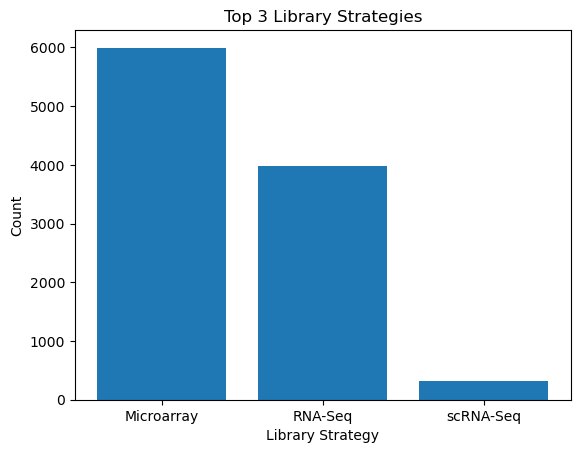

In [745]:
data = dict(df_data_info["library_strategy"].value_counts()[:3])


# Extracting labels and values
labels = list(data.keys())
values = list(data.values())

# Creating the bar plot
plt.bar(labels, values)

# Adding titles and labels
plt.xlabel("Library Strategy")
plt.ylabel("Count")
plt.title("Top 3 Library Strategies")

# Show the plot
plt.savefig(
    os.path.join(output_path_figures, "DiSignAtlas.type_of_data.png"),
    dpi=300,
    bbox_inches="tight",
)

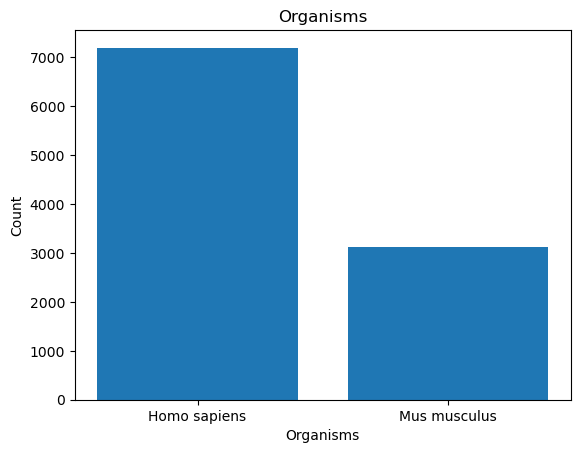

In [746]:
data = dict(df_data_info["organism"].value_counts()[:2])


# Extracting labels and values
labels = list(data.keys())
values = list(data.values())

# Creating the bar plot
plt.bar(labels, values)

# Adding titles and labels
plt.xlabel("Organisms")
plt.ylabel("Count")
plt.title("Organisms")

plt.savefig(
    os.path.join(output_path_figures, "DiSignAtlas.organisms.png"),
    dpi=300,
    bbox_inches="tight",
)

### * How recent?

In [8]:
# choose 100 random elements from the list
accessions = df_data_info["accession"].to_list()

subsample_accessions = random.sample(accessions, 100)


years = list()
for accession in tqdm(subsample_accessions):
    try:
        date = get_date_from_geo(accession)
        years.append(int(date.split(", ")[1]))
    except:
        logging.info(f"Failed to retrieve date for {accession}")
        pass

100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


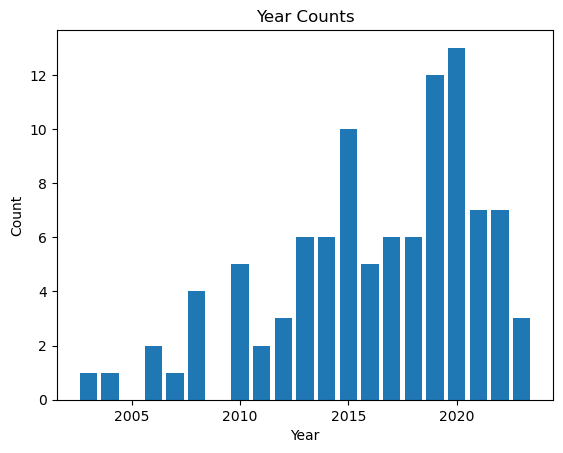

In [747]:
from collections import Counter

# Count the occurrences of each year
year_counts = Counter(years)

# Sort the years and get corresponding counts
sorted_years = sorted(year_counts.keys())
sorted_counts = [year_counts[year] for year in sorted_years]

# Create the bar plot
plt.bar(sorted_years, sorted_counts)

# Adding labels and title
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Year Counts")

plt.savefig(
    os.path.join(output_path_figures, "DiSignAtlas.recency.png"),
    dpi=300,
    bbox_inches="tight",
)

### * Which is the overlap with iLINCS datasets?

In [10]:
# Assuming fetch_disease_signatures and fetch_dataset_metadata are predefined functions
signatures = fetch_disease_signatures()
datasets = list(set([s["datasetid"] for s in signatures if filter_criteria(s)]))


# Creating a pool of worker processes
pool = multiprocessing.Pool(multiprocessing.cpu_count())

# Map process_dataset over all datasets
results = list(tqdm(pool.imap(process_dataset, datasets), total=len(datasets)))

# Closing the pool and waiting for all processes to complete
pool.close()
pool.join()

# Assigning results to iLINCS_gds_ids
iLINCS_gds_ids = results

100%|██████████| 1087/1087 [00:19<00:00, 55.11it/s]


In [11]:
logging.info(
    f"Retrieved a total of {len(iLINCS_gds_ids)} iLINCS GDS IDs {len(set(iLINCS_gds_ids))} unique"
)

2024-01-16 11:27:40,487 - INFO - Retrieved a total of 1087 iLINCS GDS IDs 1084 unique


In [12]:
# Process the iLINCS GDS IDs -> GSE IDs
results = list()
for iLINCS_gds_id in tqdm(iLINCS_gds_ids):
    results.append(process_id(iLINCS_gds_id))
# Convert results to dictionary
gds_2_gse = dict(results)

100%|██████████| 1087/1087 [26:36<00:00,  1.47s/it]


In [13]:
logging.info(
    f"Retrieved a total of {len([k for k, v in gds_2_gse.items() if v.startswith('GSE')])}/{len(gds_2_gse)} GDS to GSE mappings"
)

2024-01-16 11:54:17,042 - INFO - Retrieved a total of 1050/1084 GDS to GSE mappings


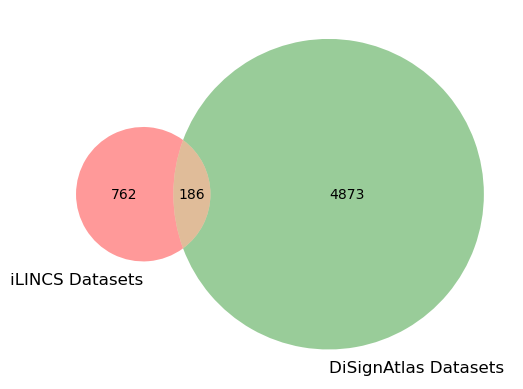

In [748]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Define the two lists
list1 = [v for k, v in gds_2_gse.items() if v.startswith("GSE")]
list2 = accessions

# Create the Venn diagram
venn2([set(list1), set(list2)], set_labels=("iLINCS Datasets", "DiSignAtlas Datasets"))

# Save plot
plt.savefig(
    os.path.join(output_path_figures, "DiSignAtlas.overlap_with_iLINCS.png"),
    dpi=300,
    bbox_inches="tight",
)

In [754]:
list(set(list1) & set(list2))[:10]

['GSE15824',
 'GSE1767',
 'GSE4172',
 'GSE6364',
 'GSE28315',
 'GSE9476',
 'GSE12452',
 'GSE3185',
 'GSE21942',
 'GSE1402']

In [ ]:
gds_2_gse

In [756]:
df_data_info[df_data_info["accession"].isin(["GSE21942"])]

dsaid accession platform  deg_count             disease diseaseid  \
1881  DSA01882  GSE21942   GPL570       1000  Multiple Sclerosis  C0026769   

     tissue data_source library_strategy      organism  \
1881    NaN         GEO       Microarray  Homo sapiens   

     control_case_sample_count  \
1881                     15|14   

                                             definition  
1881  DO:A demyelinating disease that involves damag...

In [755]:
[k for k, v in gds_2_gse.items() if v == "GSE21942"]

['GDS3920']

In [911]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 5.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 9.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [968]:
gse_2_gds = {v: k for k, v in gds_2_gse.items()}

### * Which is the correlation between both methods?

/tmp/ipykernel_618920/3125488530.py:34: DtypeWarning: Columns (0,3,7,8,9,10,15,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_iLINCS_signatures = pd.read_csv(path)
/tmp/ipykernel_618920/3125488530.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iLINCS_disease_signatures["datasetid"] = df_iLINCS_disease_signatures[
2024-01-23 17:57:23,476 - INFO - iLINCS ID: GDS_3996, level1: healthy_control, level2: Multiple_sclerosis


Batch 0


2024-01-23 17:57:25,641 - INFO - Total number of genes of iLINCS: 19685
2024-01-23 17:57:25,642 - INFO - Total number of genes of DiSignAtlas: 20486
2024-01-23 17:57:25,642 - INFO - Total number of genes of both: 21658
2024-01-23 17:57:25,642 - INFO - Total number of genes of intersection: 18513


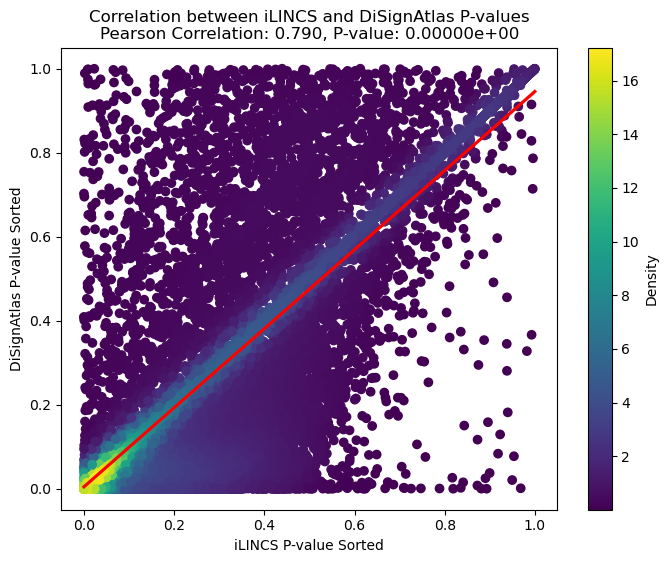

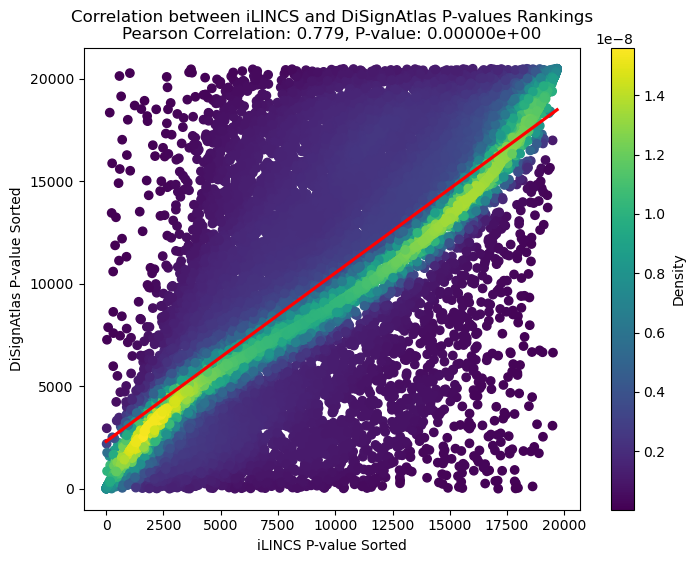

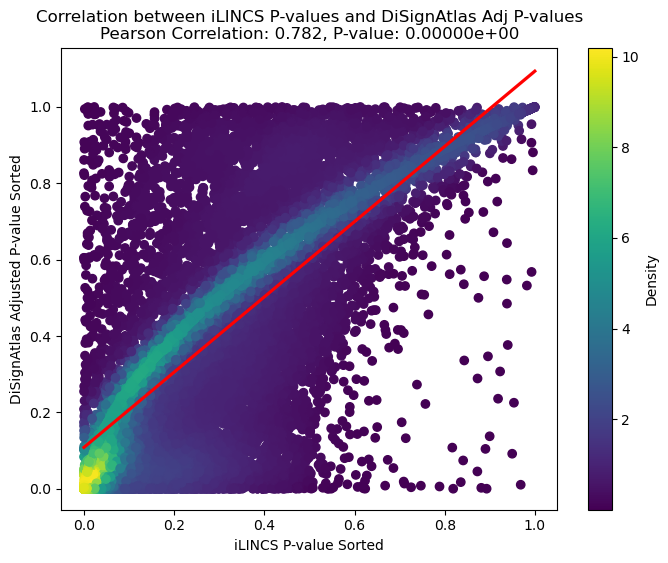

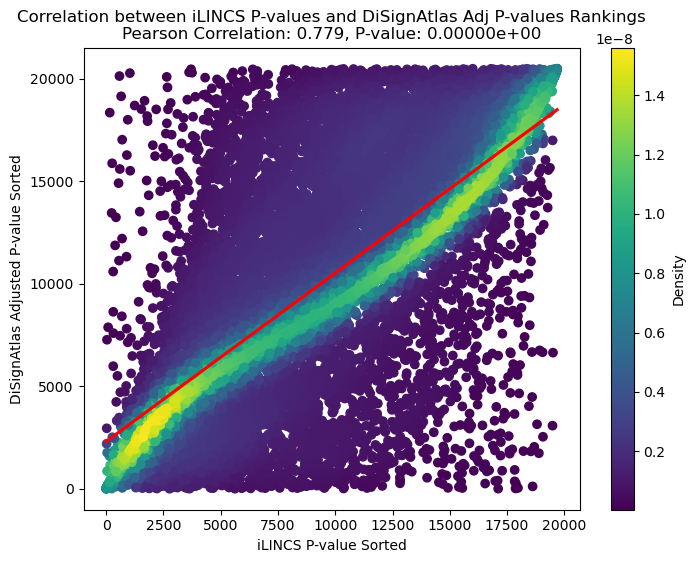

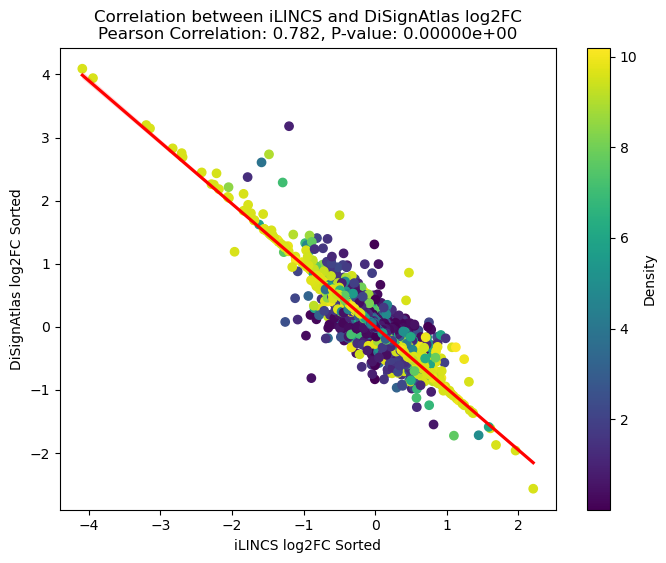

In [970]:
"""Here we aim to check what is the correlation between the computed p-values and
log2 fold changes for signatures derived from same microarray dataset in iLINCS
and DiSignAtlas.

Steps:
    a. Retrieve overlapping signatures
    b. Compute correlation between p-values and log2 fold changes
    c. Plot results
"""
# imputs

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.stats.multitest as smt

# variables

# signatures of interest
signatures_interest_gse = ["GSE21942"]

# functions


def get_iLINCS_signature_id(dataset_id):
    """Load iLINCS Signatures and return all signature IDs for a given dataset ID.
    Arguments:
        - dataset_id(str): Dataset ID
    Returns:
        - list: List of signature IDs
    """
    path = os.path.join("..", "data", "iLINCS", "signatures.csv")
    df_iLINCS_signatures = pd.read_csv(path)

    # Filter for signatures where libraryid is 'LIB_1'
    df_iLINCS_disease_signatures = df_iLINCS_signatures[
        df_iLINCS_signatures["libraryid"] == "LIB_1"
    ]

    # Remove 'gds' prefix from dataset IDs and find matching signature IDs
    df_iLINCS_disease_signatures["datasetid"] = df_iLINCS_disease_signatures[
        "datasetid"
    ].apply(lambda x: x.replace("gds", ""))

    # Filter the DataFrame for rows with the given dataset ID
    filtered_df = df_iLINCS_disease_signatures[
        df_iLINCS_disease_signatures["datasetid"] == dataset_id
    ]

    # Return a list of signature IDs
    return (
        filtered_df["signatureid"].tolist(),
        filtered_df["level1"].tolist(),
        filtered_df["level2"].tolist(),
    )


def download_iLINCS_batch_signature_data(
    signature_ids, no_of_top_genes, display, batch_size=10
):
    """
    Download iLINCS Signature Data - optimized for Batch downloads

    Arguments:
    - signature_ids: list of str
        List of signature IDs
    - no_of_top_genes: int
        Number of top differentially expressed genes
    - display: bool
        Whether to display the data
    - batch_size: int
        Number of signatures to download in each batch

    Returns:
    - processed_data: dict
        Dictionary with SignatureID -> [{}]
    """
    endpoint = "http://www.ilincs.org/api/ilincsR/downloadSignature"
    processed_data = {}

    for i in range(0, len(signature_ids), batch_size):
        print(f"Batch {i}", end="\r")

        batch_ids = signature_ids[i : i + batch_size]
        data = {
            "sigID": ",".join(batch_ids),
            "noOfTopGenes": no_of_top_genes,
            "display": display,
        }
        response = requests.post(endpoint, data=data)
        if response.status_code == 200:
            raw_data = response.json()
            for item in raw_data["data"]["signature"]:
                signatureID = item["signatureID"]
                if signatureID not in processed_data:
                    processed_data[signatureID] = []
                processed_data[signatureID].append(item)

        else:
            print(
                f"Error in batch {i // batch_size + 1}: {response.status_code}, {response.text}"
            )

    print()
    return processed_data


def process_iLINCS_signature_data(signature_data):
    gene_ids = list()
    p_values = list()
    de_values = list()
    ranking_p_values = list()
    for item in signature_data:
        gene_ids.append(item["ID_geneid"])
        p_values.append(item["Significance_pvalue"])
        de_values.append(item["Value_LogDiffExp"])

    # argsort()[::-1] returns the indices that would sort the array in descending order
    # argsort(argsort()[::-1]) then gives the ranks starting from 0, so we add 1 to start from 1
    ranking_p_values = (np.array(p_values).argsort()[::-1].argsort() + 1).tolist()
    return gene_ids, p_values, ranking_p_values, de_values


def get_DiSignAtlas_signature(dsaid):
    """
    Calculate signed significance for each gene in the signature.
    Args:
        - dsaid: str

    Returns:
        - gene_ids: list
            List of gene IDs
        - p_values: list
            List of p-values
        - de_values: list
            List of log2 fold changes
    """
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )

    df = pd.read_csv(data_path, sep="\t")

    gene_ids = list()
    p_values = list()
    adj_p_values = list()
    de_values = list()
    for index, row in df.iterrows():
        # Handle cases where AdjPValue is 0
        # or nan values
        # if (row["AdjPValue"] != 0) and (not np.isnan(row["AdjPValue"])):
        de_values.append(row["Log2FC"])
        p_values.append(row["PValue"])
        adj_p_values.append(row["AdjPValue"])
        gene_ids.append(row["GeneID"])

    # argsort()[::-1] returns the indices that would sort the array in descending order
    # argsort(argsort()[::-1]) then gives the ranks starting from 0, so we add 1 to start from 1
    ranking_p_values = (np.array(p_values).argsort()[::-1].argsort() + 1).tolist()
    ranking_adj_p_values = (
        np.array(adj_p_values).argsort()[::-1].argsort() + 1
    ).tolist()

    return (
        gene_ids,
        p_values,
        adj_p_values,
        ranking_p_values,
        ranking_adj_p_values,
        de_values,
    )


def sort_list_values(list_1, list_2, values_2):
    """Sort List Values - sort list_1 based on list_2 values.
    Arguments:
        - list_1(list): List to be sorted
        - list_2(list): List of values to sort by
        - values_2(list): List of values to return
    Returns:
        - sorted_values_2: Sorted list
    """
    list_2_values = dict(zip(list_2, values_2))
    sorted_values_2 = [list_2_values[i] for i in list_1]
    assert len(sorted_values_2) == len(list_1), "Err in sorting"
    return sorted_values_2


for gse in signatures_interest_gse:
    # a. Retrieve overlapping signatures
    # convert GDS to GSE
    dataset_gds = gse_2_gds.get(gse)
    # gse = gds_2_gse.get(dataset_gds)

    # load all iLINCS signature metadata
    iLINCS_ids, level1s, level2s = get_iLINCS_signature_id(dataset_id=dataset_gds)

    assert len(iLINCS_ids) == 1, "More than one signature!!"

    iLINCS_id = iLINCS_ids[0]
    level1 = level1s[0]
    level2 = level2s[0]
    logging.info(f"iLINCS ID: {iLINCS_id}, level1: {level1}, level2: {level2}")
    # get iLINCS signatures
    iLINCS_batch_signature = download_iLINCS_batch_signature_data(
        signature_ids=[iLINCS_id], no_of_top_genes=100000, display=True, batch_size=20
    )

    iLINCS_signature = iLINCS_batch_signature[iLINCS_id]
    (
        iLINCS_genes,
        iLINCS_pvalue,
        iLINCS_ranking_pvalue,
        iLINCS_de,
    ) = process_iLINCS_signature_data(iLINCS_signature)

    # get DiSignAtlas ID from GDS
    DiSginAtlas_ids = df_data_info[df_data_info["accession"] == gse]["dsaid"].values

    assert len(DiSginAtlas_ids) == 1, "More than one signature!!"

    DiSginAtlas_id = DiSginAtlas_ids[0]

    # get DiSignAtlas signatures
    (
        DiSginAtlas_genes,
        DiSginAtlas_pvalue,
        DiSginAtlas_adj_pvalue,
        DiSginAtlas_ranking_pvalue,
        DiSginAtlas_ranking_adj_pvalue,
        DiSginAtlas_de,
    ) = get_DiSignAtlas_signature(DiSginAtlas_id)

    # sort both signatures by gene id
    # get list of both genes together
    all_genes = list(set(iLINCS_genes + DiSginAtlas_genes))

    common_genes = list(set(iLINCS_genes).intersection(set(DiSginAtlas_genes)))

    logging.info(f"Total number of genes of iLINCS: {len(iLINCS_genes)}")
    logging.info(f"Total number of genes of DiSignAtlas: {len(DiSginAtlas_genes)}")
    logging.info(f"Total number of genes of both: {len(all_genes)}")
    logging.info(f"Total number of genes of intersection: {len(common_genes)}")

    DiSginAtlas_pvalue_sorted = sort_list_values(
        list_1=common_genes, list_2=DiSginAtlas_genes, values_2=DiSginAtlas_pvalue
    )
    DiSginAtlas_adj_pvalue_sorted = sort_list_values(
        list_1=common_genes, list_2=DiSginAtlas_genes, values_2=DiSginAtlas_adj_pvalue
    )

    DiSginAtlas_ranking_pvalue_sorted = sort_list_values(
        list_1=common_genes,
        list_2=DiSginAtlas_genes,
        values_2=DiSginAtlas_ranking_pvalue,
    )
    DiSginAtlas_ranking_adj_pvalue_sorted = sort_list_values(
        list_1=common_genes,
        list_2=DiSginAtlas_genes,
        values_2=DiSginAtlas_ranking_adj_pvalue,
    )
    DiSginAtlas_de_sorted = sort_list_values(
        list_1=common_genes, list_2=DiSginAtlas_genes, values_2=DiSginAtlas_de
    )

    iLINCS_pvalue_sorted = sort_list_values(
        list_1=common_genes, list_2=iLINCS_genes, values_2=iLINCS_pvalue
    )
    iLINCS_ranking_pvalue_sorted = sort_list_values(
        list_1=common_genes, list_2=iLINCS_genes, values_2=iLINCS_ranking_pvalue
    )
    iLINCS_de_sorted = sort_list_values(
        list_1=common_genes, list_2=iLINCS_genes, values_2=iLINCS_de
    )

    # c.1 Plot results pvalues
    # Compute Pearson correlation
    correlation, p_value = stats.pearsonr(
        iLINCS_pvalue_sorted, DiSginAtlas_pvalue_sorted
    )

    # Calculate the point density
    xy = np.vstack([iLINCS_pvalue_sorted, DiSginAtlas_pvalue_sorted])
    z = stats.gaussian_kde(xy)(xy)

    # Plotting
    plt.figure(figsize=(8, 6))

    # Create a scatter plot colored by density
    plt.scatter(
        x=iLINCS_pvalue_sorted, y=DiSginAtlas_pvalue_sorted, c=z, cmap="viridis"
    )

    # Add a regression line
    sns.regplot(
        x=iLINCS_pvalue_sorted, y=DiSginAtlas_pvalue_sorted, scatter=False, color="red"
    )

    # Add titles and labels
    plt.title(
        f"Correlation between iLINCS and DiSignAtlas P-values\n"
        f"Pearson Correlation: {correlation:.3f}, P-value: {p_value:.5e}"
    )
    plt.xlabel("iLINCS P-value Sorted")
    plt.ylabel("DiSignAtlas P-value Sorted")
    plt.colorbar(label="Density")

    # c.2 Plot ranking pvalues
    # Compute Pearson correlation
    correlation, p_value = stats.pearsonr(
        iLINCS_ranking_pvalue_sorted, DiSginAtlas_ranking_pvalue_sorted
    )

    # Calculate the point density
    xy = np.vstack([iLINCS_ranking_pvalue_sorted, DiSginAtlas_ranking_pvalue_sorted])
    z = stats.gaussian_kde(xy)(xy)

    # Plotting
    plt.figure(figsize=(8, 6))

    # Create a scatter plot colored by density
    plt.scatter(
        x=iLINCS_ranking_pvalue_sorted,
        y=DiSginAtlas_ranking_pvalue_sorted,
        c=z,
        cmap="viridis",
    )

    # Add a regression line
    sns.regplot(
        x=iLINCS_ranking_pvalue_sorted,
        y=DiSginAtlas_ranking_pvalue_sorted,
        scatter=False,
        color="red",
    )

    # Add titles and labels
    plt.title(
        f"Correlation between iLINCS and DiSignAtlas P-values Rankings\n"
        f"Pearson Correlation: {correlation:.3f}, P-value: {p_value:.5e}"
    )
    plt.xlabel("iLINCS P-value Sorted")
    plt.ylabel("DiSignAtlas P-value Sorted")
    plt.colorbar(label="Density")

    # c.3 Plot results adj pvalues
    # Compute Pearson correlation
    correlation, p_value = stats.pearsonr(
        iLINCS_pvalue_sorted, DiSginAtlas_adj_pvalue_sorted
    )

    # Calculate the point density
    xy = np.vstack([iLINCS_pvalue_sorted, DiSginAtlas_adj_pvalue_sorted])
    z = stats.gaussian_kde(xy)(xy)

    # Plotting
    plt.figure(figsize=(8, 6))

    # Create a scatter plot colored by density
    plt.scatter(
        x=iLINCS_pvalue_sorted, y=DiSginAtlas_adj_pvalue_sorted, c=z, cmap="viridis"
    )

    # Add a regression line
    sns.regplot(
        x=iLINCS_pvalue_sorted,
        y=DiSginAtlas_adj_pvalue_sorted,
        scatter=False,
        color="red",
    )

    # Add titles and labels
    plt.title(
        f"Correlation between iLINCS P-values and DiSignAtlas Adj P-values\n"
        f"Pearson Correlation: {correlation:.3f}, P-value: {p_value:.5e}"
    )
    plt.xlabel("iLINCS P-value Sorted")
    plt.ylabel("DiSignAtlas Adjusted P-value Sorted")
    plt.colorbar(label="Density")

    # c.4 Plot results ranking adjusted pvalues
    # Compute Pearson correlation
    correlation, p_value = stats.pearsonr(
        iLINCS_ranking_pvalue_sorted, DiSginAtlas_ranking_adj_pvalue_sorted
    )

    # Calculate the point density
    xy = np.vstack(
        [iLINCS_ranking_pvalue_sorted, DiSginAtlas_ranking_adj_pvalue_sorted]
    )
    z = stats.gaussian_kde(xy)(xy)

    # Plotting
    plt.figure(figsize=(8, 6))

    # Create a scatter plot colored by density
    plt.scatter(
        x=iLINCS_ranking_pvalue_sorted,
        y=DiSginAtlas_ranking_adj_pvalue_sorted,
        c=z,
        cmap="viridis",
    )

    # Add a regression line
    sns.regplot(
        x=iLINCS_ranking_pvalue_sorted,
        y=DiSginAtlas_ranking_adj_pvalue_sorted,
        scatter=False,
        color="red",
    )

    # Add titles and labels
    plt.title(
        f"Correlation between iLINCS P-values and DiSignAtlas Adj P-values Rankings\n"
        f"Pearson Correlation: {correlation:.3f}, P-value: {p_value:.5e}"
    )
    plt.xlabel("iLINCS P-value Sorted")
    plt.ylabel("DiSignAtlas Adjusted P-value Sorted")
    plt.colorbar(label="Density")

    # c.5 Plot results log2FCs
    # Compute Pearson correlation
    correlation, p_value = stats.pearsonr(
        iLINCS_pvalue_sorted, DiSginAtlas_adj_pvalue_sorted
    )

    # Calculate the point density
    xy = np.vstack([iLINCS_pvalue_sorted, DiSginAtlas_adj_pvalue_sorted])
    z = stats.gaussian_kde(xy)(xy)

    # Plotting
    plt.figure(figsize=(8, 6))

    # Create a scatter plot colored by density

    plt.scatter(x=iLINCS_de_sorted, y=DiSginAtlas_de_sorted, c=z, cmap="viridis")

    # Add a regression line
    sns.regplot(
        x=iLINCS_de_sorted,
        y=DiSginAtlas_de_sorted,
        scatter=False,
        color="red",
    )

    # Add titles and labels
    plt.title(
        f"Correlation between iLINCS and DiSignAtlas log2FC\n"
        f"Pearson Correlation: {correlation:.3f}, P-value: {p_value:.5e}"
    )
    plt.xlabel("iLINCS log2FC Sorted")
    plt.ylabel("DiSignAtlas log2FC Sorted")
    plt.colorbar(label="Density")

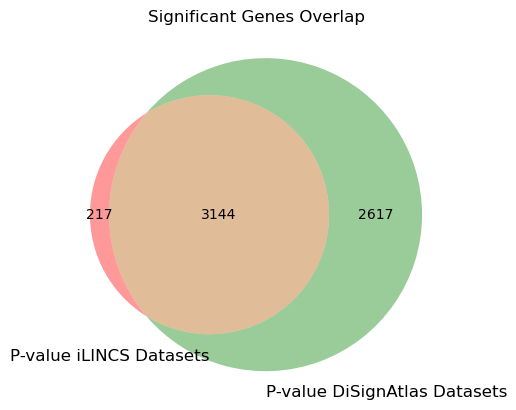

In [967]:
# c.6 Plot significant genes overlap
# Define the two lists
significant_iLINCS = [
    gene for gene, p_value in zip(common_genes, iLINCS_pvalue_sorted) if p_value < 0.05
]
significant_DiSignAtlas = [
    gene
    for gene, p_value in zip(common_genes, DiSginAtlas_pvalue_sorted)
    if p_value < 0.05
]

# Create the Venn diagram
plt.title("Significant Genes Overlap")
venn2(
    [set(significant_iLINCS), set(significant_DiSignAtlas)],
    set_labels=("P-value iLINCS Datasets", "P-value DiSignAtlas Datasets"),
)

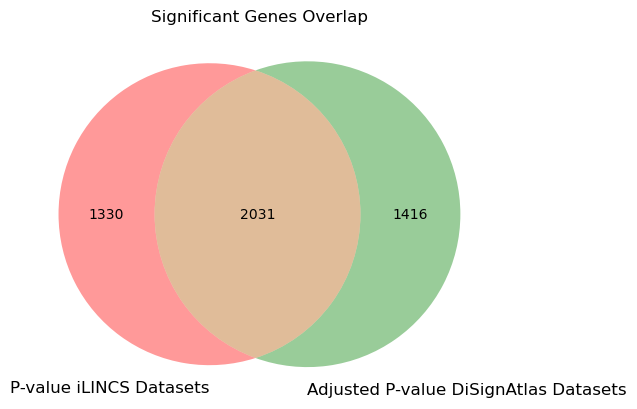

In [971]:
# c.6 Plot significant genes overlap
# Define the two lists
significant_iLINCS = [
    gene for gene, p_value in zip(common_genes, iLINCS_pvalue_sorted) if p_value < 0.05
]
significant_DiSignAtlas = [
    gene
    for gene, p_value in zip(common_genes, DiSginAtlas_adj_pvalue_sorted)
    if p_value < 0.05
]

# Create the Venn diagram
plt.title("Significant Genes Overlap")
venn2(
    [set(significant_iLINCS), set(significant_DiSignAtlas)],
    set_labels=("P-value iLINCS Datasets", "Adjusted P-value DiSignAtlas Datasets"),
)

In [1012]:
a = np.array([1, 2, 3, 4, 5, 6])
b = np.array([11, 1, 56, 23, 88])

indxs = np.argpartition(b, 2)[:2]
b[indxs]

array([ 1, 11])

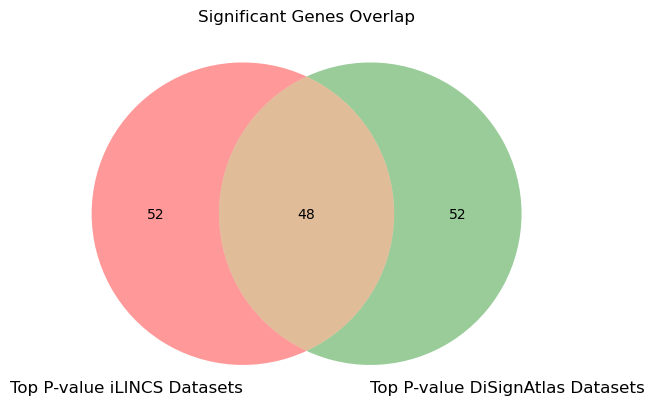

In [1021]:
# Compute TOP 100 significant up-regulated & down-regulated genes
import numpy as np


def get_top_bottom_k_np(labels, values, k):
    """
    Get top k and bottom k values and their corresponding labels using NumPy's argpartition.

    :param labels: List of labels.
    :param values: List of values corresponding to labels.
    :param k: Number of top and bottom elements to retrieve.
    :return: A tuple of two lists - top k labels and bottom k labels.
    """
    if k > len(labels) // 2:
        raise ValueError(
            "k is too large. It must be less than or equal to half the length of the labels list."
        )

    values_array = np.array(values)

    # Get indices for bottom k and top k
    bottom_k_indices = np.argpartition(values_array, k)[:k]
    top_k_indices = np.argpartition(values_array, -k)[-k:]

    # Retrieve corresponding labels
    top_k_labels = [labels[index] for index in top_k_indices]
    bottom_k_labels = [labels[index] for index in bottom_k_indices]

    return top_k_labels, bottom_k_labels


# get top and bottom 100 significant genes
DiSignAtlas_top_pvalue, DiSignAtlas_bottom_pvalue = get_top_bottom_k_np(
    labels=common_genes, values=DiSginAtlas_pvalue_sorted, k=100
)

# get top and bottom 100 significant genes
iLINCS_top_pvalue, iLINCS_bottom_pvalue = get_top_bottom_k_np(
    labels=common_genes, values=iLINCS_pvalue_sorted, k=100
)

# Create the Venn diagram
plt.title("Significant Genes Overlap")
venn2(
    [set(iLINCS_top_pvalue), set(DiSignAtlas_top_pvalue)],
    set_labels=("Top P-value iLINCS Datasets", "Top P-value DiSignAtlas Datasets"),
)

In [1019]:
# Create the Venn diagram
plt.title("Significant Genes Overlap")
venn2(
    [set(iLINCS_bottom_pvalue), set(DiSignAtlas_bottom_pvalue)],
    set_labels=(
        "Bottom P-value iLINCS Datasets",
        "Bottom P-value DiSignAtlas Datasets",
    ),
)

In [993]:
len(
    [
        gene
        for gene, p_value in zip(common_genes, DiSginAtlas_adj_pvalue_sorted)
        if p_value < 0.05
    ]
)

3447

In [992]:
len(DiSginAtlas_adj_pvalue)

20486

(array([2104.,  505.,  403.,  313.,  271.,  297.,  229.,  248.,  198.,
         219.,  247.,  220.,  158.,  211.,  152.,  173.,  156.,  189.,
         167.,  182.,  165.,  136.,  199.,  179.,  203.,  182.,  187.,
         162.,  258.,  195.,  176.,  188.,  160.,  228.,  165.,  193.,
         169.,  185.,  205.,  214.,  192.,  179.,  171.,  201.,  140.,
         162.,  175.,  182.,  147.,  132.,  178.,  153.,  171.,  186.,
         164.,  159.,  179.,  168.,  164.,  156.,  212.,  175.,  138.,
         164.,  175.,  173.,  161.,  130.,  154.,  145.,  146.,  160.,
         188.,  172.,  164.,  162.,  147.,  156.,  122.,  170.,  153.,
         179.,  179.,  154.,  165.,  121.,  192.,  156.,  172.,  200.,
         167.,  214.,  179.,  172.,  171.,  203.,  189.,  159.,  178.,
         219.]),
 array([1.96613826e-09, 9.99784692e-03, 1.99956919e-02, 2.99935368e-02,
        3.99913818e-02, 4.99892267e-02, 5.99870717e-02, 6.99849167e-02,
        7.99827616e-02, 8.99806066e-02, 9.99784515e-02, 1.

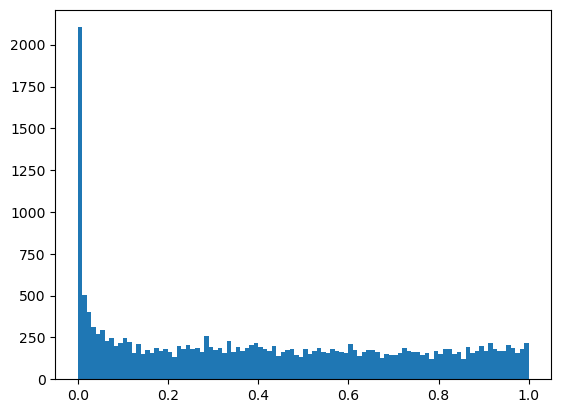

In [989]:
plt.hist(DiSginAtlas_adj_pvalue, bins=100)

In [909]:
[s for s in iLINCS_signature if s["ID_geneid"] == 104]

[{'signatureID': 'GDS_3996',
  'PROBE': 'NA',
  'ID_geneid': 104,
  'Name_GeneSymbol': 'ADARB1',
  'Value_LogDiffExp': -0.10805,
  'Significance_pvalue': 0.5529293192}]

In [942]:
# Alternative method to calculate the ranks

import numpy as np

# Convert the list to a numpy array for efficient computation
values = np.array([0.000000001, 0.5, 0.0000000000000000000000001, 0.3])

# argsort() returns the indices that would sort the array
# argsort().argsort() then gives the ranks starting from 0, so we add 1 to start from 1
ranks_alternative = values.argsort().argsort() + 1
ranks_alternative.tolist()

[2, 4, 1, 3]

In [948]:
((values * -1).argsort() + 1)

array([2, 4, 1, 3])

In [903]:
iLINCS_signature

[{'signatureID': 'GDS_3996',
  'PROBE': 'NA',
  'ID_geneid': 1359,
  'Name_GeneSymbol': 'CPA3',
  'Value_LogDiffExp': -2.8291,
  'Significance_pvalue': 8.046562989e-12},
 {'signatureID': 'GDS_3996',
  'PROBE': 'NA',
  'ID_geneid': 3703,
  'Name_GeneSymbol': 'STT3A',
  'Value_LogDiffExp': 1.60928,
  'Significance_pvalue': 1.520446651e-11},
 {'signatureID': 'GDS_3996',
  'PROBE': 'NA',
  'ID_geneid': 9924,
  'Name_GeneSymbol': 'PAN2',
  'Value_LogDiffExp': -0.645371,
  'Significance_pvalue': 4.084607323e-11},
 {'signatureID': 'GDS_3996',
  'PROBE': 'NA',
  'ID_geneid': 6184,
  'Name_GeneSymbol': 'RPN1',
  'Value_LogDiffExp': 1.1386,
  'Significance_pvalue': 4.094062592e-11},
 {'signatureID': 'GDS_3996',
  'PROBE': 'NA',
  'ID_geneid': 4057,
  'Name_GeneSymbol': 'LTF',
  'Value_LogDiffExp': -3.94234,
  'Significance_pvalue': 8.006050262e-11},
 {'signatureID': 'GDS_3996',
  'PROBE': 'NA',
  'ID_geneid': 22820,
  'Name_GeneSymbol': 'COPG1',
  'Value_LogDiffExp': 1.32006,
  'Significance_pva

In [908]:
[
    c
    for c, d, i in zip(common_genes, DiSginAtlas_pvalue_sorted, iLINCS_pvalue_sorted)
    if (d > 0.5 and i < 0.05) or (d < 0.05 and i > 0.5)
]

[104,
 538,
 843,
 644794,
 1121,
 2011,
 2683,
 2932,
 2958,
 91775,
 134145,
 3554,
 3954,
 3964,
 4124,
 4249,
 4336,
 4714,
 5079,
 5469,
 5494,
 6201,
 6202,
 6233,
 6917,
 7153,
 7158,
 400506,
 7332,
 7582,
 401152,
 8394,
 8476,
 8569,
 8721,
 8821,
 9141,
 9261,
 9262,
 9371,
 9419,
 9470,
 9501,
 9516,
 9554,
 9616,
 9643,
 10016,
 10428,
 10487,
 11091,
 11127,
 11163,
 339483,
 79084,
 79364,
 79815,
 112869,
 440944,
 440957,
 146434,
 81037,
 124359,
 81577,
 81611,
 114799,
 50515,
 83479,
 55672,
 83700,
 83737,
 51077,
 51086,
 55796,
 51380,
 55802,
 84186,
 55844,
 55846,
 51667,
 84766,
 150759,
 140707,
 151242,
 151987,
 283104,
 119392,
 53918,
 644150,
 414777,
 54741,
 54800,
 317662,
 55553,
 22818,
 22879,
 22906,
 285512,
 23376,
 23410,
 155060,
 56981,
 56983,
 57224,
 122830,
 57406,
 57695,
 57700,
 123879,
 255027,
 207063,
 91694,
 26272,
 92255,
 252839,
 27252,
 27333,
 60496,
 159013,
 389362,
 28962,
 29058,
 29767,
 160851,
 29798,
 29886,
 100128

In [ ]:
   # c. Plot results adjusted_pvalues

    # Compute Pearson correlation
    correlation, p_value = stats.pearsonr(
        iLINCS_pvalue_sorted, DiSginAtlas_pvalue_sorted
    )

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=iLINCS_pvalue_sorted, y=DiSginAtlas_pvalue_sorted)
    sns.regplot(
        x=iLINCS_pvalue_sorted, y=DiSginAtlas_pvalue_sorted, scatter=False, color="red"
    )

    plt.title(
        f"Correlation between iLINCS and DiSignAtlas P-values\n"
        f"Pearson Correlation: {correlation:.2f}, P-value: {p_value:.2e}"
    )
    plt.xlabel("iLINCS P-value Sorted")
    plt.ylabel("DiSignAtlas P-value Sorted")

    # Display the plot
    plt.show()



/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


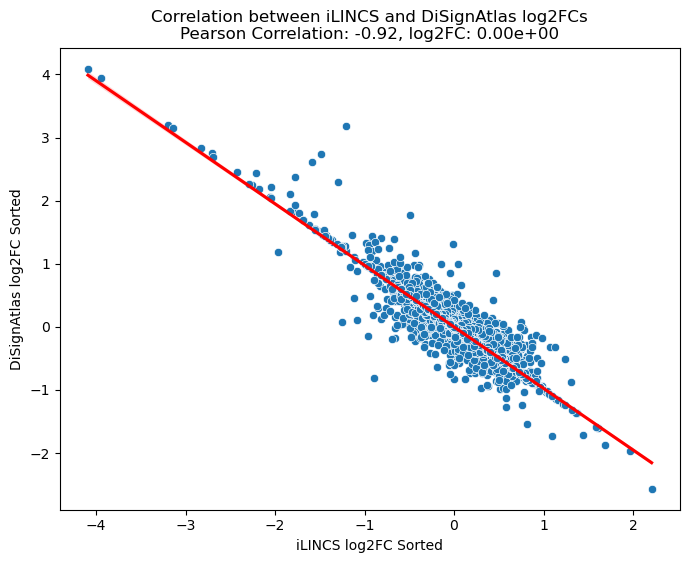

In [882]:
DiSginAtlas_ids

array(['DSA01882'], dtype=object)

In [880]:
iLINCS_batch_signature

{'GDS_3996': [{'signatureID': 'GDS_3996',
   'PROBE': 'NA',
   'ID_geneid': 1359,
   'Name_GeneSymbol': 'CPA3',
   'Value_LogDiffExp': -2.8291,
   'Significance_pvalue': 8.046562989e-12},
  {'signatureID': 'GDS_3996',
   'PROBE': 'NA',
   'ID_geneid': 3703,
   'Name_GeneSymbol': 'STT3A',
   'Value_LogDiffExp': 1.60928,
   'Significance_pvalue': 1.520446651e-11},
  {'signatureID': 'GDS_3996',
   'PROBE': 'NA',
   'ID_geneid': 9924,
   'Name_GeneSymbol': 'PAN2',
   'Value_LogDiffExp': -0.645371,
   'Significance_pvalue': 4.084607323e-11},
  {'signatureID': 'GDS_3996',
   'PROBE': 'NA',
   'ID_geneid': 6184,
   'Name_GeneSymbol': 'RPN1',
   'Value_LogDiffExp': 1.1386,
   'Significance_pvalue': 4.094062592e-11},
  {'signatureID': 'GDS_3996',
   'PROBE': 'NA',
   'ID_geneid': 4057,
   'Name_GeneSymbol': 'LTF',
   'Value_LogDiffExp': -3.94234,
   'Significance_pvalue': 8.006050262e-11},
  {'signatureID': 'GDS_3996',
   'PROBE': 'NA',
   'ID_geneid': 22820,
   'Name_GeneSymbol': 'COPG1',
   '

/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

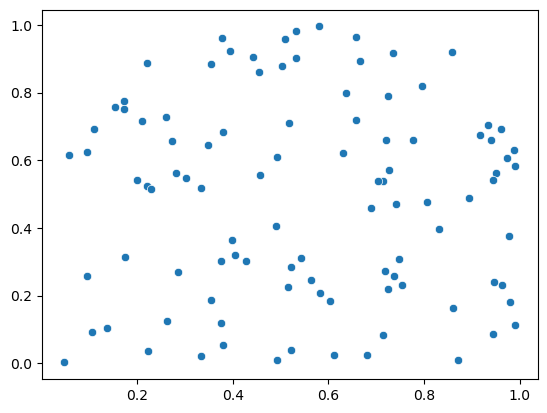

In [884]:
sns.scatterplot(x=iLINCS_pvalue_sorted, y=DiSginAtlas_pvalue_sorted)

In [ ]:
def get_iLINCS_signature_id(dataset_id):
    """Load iLINCS Signatures
    Returns:"""
    path = os.path.join("..", "data", "iLINCS", "signatures.csv")
    df_iLINCS_signatures = pd.read_csv(path)
    df_iLINCS_disease_signatures = df_iLINCS_signatures[
        df_iLINCS_signatures["libraryid"] == "LIB_1"
    ]
    # for some reason sometimes dataset ids appear as gdsGDSXXXX -
    # we should remove the gds prefix
    d_dataset_2_signatureid = dict(
        zip(
            df_iLINCS_disease_signatures["datasetid"].apply(
                lambda x: x.replace("gds,", "")
            ),
            df_iLINCS_disease_signatures["signatureid"],
        )
    )
    return d_dataset_2_signatureid.get(dataset_id)

In [835]:
dataset_id = "GDS3920"

"""Load iLINCS Signatures
Returns:"""
path = os.path.join("..", "data", "iLINCS", "signatures.csv")
df_iLINCS_signatures = pd.read_csv(path)
df_iLINCS_disease_signatures = df_iLINCS_signatures[
    df_iLINCS_signatures["libraryid"] == "LIB_1"
]
# for some reason sometimes dataset ids appear as gdsGDSXXXX -
# we should remove the gds prefix
d_dataset_2_signatureid = dict(
    zip(
        df_iLINCS_disease_signatures["datasetid"].apply(
            lambda x: x.replace("gds,", "")
        ),
        df_iLINCS_disease_signatures["signatureid"],
    )
)
print(d_dataset_2_signatureid.get(dataset_id))

None


/tmp/ipykernel_618920/225285767.py:6: DtypeWarning: Columns (0,3,7,8,9,10,15,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_iLINCS_signatures = pd.read_csv(path)


In [769]:
path = os.path.join("..", "data", "iLINCS", "signatures.csv")
df_iLINCS_signatures = pd.read_csv(path)
d_dataset_2_signatureid = dict(
    zip(df_iLINCS_signatures["datasetid"], df_iLINCS_signatures["signatureid"])
)

/tmp/ipykernel_618920/1451031359.py:2: DtypeWarning: Columns (0,3,7,8,9,10,15,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_iLINCS_signatures = pd.read_csv(path)


## c. DiSignAtlas get MeSH terms from Disease IDs

### c.1 Retrieve MeSH terms from DiSignAtlas

In [15]:
"""DiSginAtlas DataSets

The objective here is to retrieve the datasets from DiSignAtlas.

Structure:
    1. Imports, Variables and Functions
    2. Load Data
    3. Retrieve DataSets
    4. Root MeSH Terms
    5. Leaf MeSH Terms
"""

# 1. Imports, Variables and Functions
# imports
import pandas as pd, numpy as np, os, sys, re, json, pickle, time, datetime, random
import requests
import xml.etree.ElementTree as ET
import time, re
from Bio import Entrez
import logging
import pandas as pd
import json
import logging
from multiprocessing import Pool


logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
dataset_info_path = os.path.join("..", "data", "DiSignAtlas", "dis_info_datasets")
Entrez.email = "dylandaltonsub@gmail.com"
data_path = "../data/DiseaseOntology/doid.obo"  # Replace with your file path
mesh_file_path = os.path.join("..", "data", "MeSH", "desc2023.xml")


# functions
def query_disignatlas(disease_id):
    """Query DiSignAtlas for a given disease id
    Args:
        disease_id (str): The disease id to query
    Returns:
        response.text: The response text
    """
    url = f"http://www.inbirg.com/disignatlas/detail/{disease_id}"
    response = requests.get(url)

    if response.status_code != 200:
        print("Unable to retrieve data")

    return response.text


def extract_mesh_terms(js_function_str):
    """Extract the MeSH terms from the JavaScript function string
    Args:
        js_function_str (str): The JavaScript function string
    Returns:
        mesh_terms (list): The MeSH terms
    """
    # Find the start of the dbXrefs string
    start = js_function_str.find('dbXrefs = "') + len('dbXrefs = "')
    # Find the end of the dbXrefs string
    end = js_function_str.find('"', start)
    # Extract the dbXrefs string
    dbXrefs_str = js_function_str[start:end]
    # Split the string by the pipe character
    dbXrefs = dbXrefs_str.split("|")
    # Filter out and return only the MeSH terms
    mesh_terms = [x for x in dbXrefs if x.startswith("MeSH:")]
    return mesh_terms


def extract_do_terms(js_function_str):
    """Extract the Disease Ontology terms from the JavaScript function string
    Args:
        js_function_str (str): The JavaScript function string
    Returns:
        do_terms (list): The DO terms
    """
    # Find the start of the dbXrefs string
    start = js_function_str.find('dbXrefs = "') + len('dbXrefs = "')
    # Find the end of the dbXrefs string
    end = js_function_str.find('"', start)
    # Extract the dbXrefs string
    dbXrefs_str = js_function_str[start:end]
    # Split the string by the pipe character
    dbXrefs = dbXrefs_str.split("|")
    # Filter out and return only the MeSH terms
    do_terms = [x for x in dbXrefs if x.startswith("DO:")]
    return do_terms


def process_disease_id_mesh(disease_id):
    # Retrieve data
    data = query_disignatlas(disease_id)
    # Extract mesh terms
    mesh_terms = extract_mesh_terms(data)
    # Return a tuple of disease_id and mesh_terms
    return disease_id, mesh_terms


def process_disease_id_do(disease_id):
    # Retrieve data
    data = query_disignatlas(disease_id)
    # Extract mesh terms
    do_terms = extract_do_terms(data)
    # Return a tuple of disease_id and mesh_terms
    return disease_id, do_terms


def parse_obo_file(file_path):
    with open(file_path, "r") as file:
        content = file.read()

    # Splitting the content into entries for each term
    terms = content.split("\n[Term]")
    mesh_terms = {}

    for term in terms:
        lines = term.split("\n")
        do_id = None
        mesh_id = None
        for line in lines:
            if line.startswith("id:"):
                do_id = line.split(": ")[1]
            if "xref: MESH:" in line:
                mesh_id = line.split("MESH:")[1].strip()
                if do_id and mesh_id:
                    if do_id in mesh_terms:
                        mesh_terms[do_id].append(mesh_id)
                    else:
                        mesh_terms[do_id] = [mesh_id]

    return mesh_terms


def find_mesh_tree_terms(mesh_ids, file_path):
    # Load and parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Create a dictionary to store tree terms for each MeSH ID
    mesh_tree_terms_dict = {mesh_id: None for mesh_id in mesh_ids}

    # Iterate through the XML to find each MeSH ID
    for descriptor in root.findall(".//DescriptorRecord"):
        descriptor_id = descriptor.find("./DescriptorUI")
        if descriptor_id is not None and descriptor_id.text in mesh_ids:
            # Extract tree terms
            tree_numbers = [tn.text for tn in descriptor.findall(".//TreeNumber")]
            mesh_tree_terms_dict[descriptor_id.text] = tree_numbers

    return mesh_tree_terms_dict


def build_mesh_term_tree_number_mapping(mesh_xml_file_path: str) -> dict:
    """
    Build a mapping of MeSH terms to their tree numbers from the MeSH XML file.

    Parameters:
    - mesh_xml_file_path (str): The file path to the MeSH XML file.

    Returns:
    - dict: A dictionary where keys are MeSH terms and values are lists of associated tree numbers.
    """
    tree = ET.parse(mesh_xml_file_path)
    root = tree.getroot()

    mesh_term_2_symbols = dict()
    mesh_symbol_2_term = dict()
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        tree_numbers = [
            tree_number.text
            for tree_number in descriptor.findall("TreeNumberList/TreeNumber")
        ]
        for tree_number in tree_numbers:
            mesh_symbol_2_term[tree_number] = term
        mesh_term_2_symbols[term] = tree_numbers

    return mesh_term_2_symbols, mesh_symbol_2_term


def get_dsaids_with_term(term_interest, dsaids, disease_id_2_mesh):
    """Get DSAIDs with Term
    Arguments:
        term_interest (str): term of interest
        dsaid (list): list of dsaids
        disease_id_2_mesh (dict): dictionary of dsaids and their symbols
    Returns:
        found_dsaids (list): list of dsaids which have the term of interest
    """

    found_dsaids = list()

    # iterate through datasets & their symbols
    for dsaid in dsaids:
        symbols = disease_id_2_mesh[dsaid]["symbols"]
        symbols_disease = [s for s in symbols if s.startswith("C")]

        # iterate through different symbols
        for symbol in symbols_disease:
            symbol_levels = symbol.split(".")
            flag = False

            # iterate through different symbol levels
            for i in range(len(symbol_levels)):
                symbol_level = ".".join(symbol_levels[: i + 1])
                term = mesh_symbol_2_term[symbol_level]

                # if term belongs to branch terms of interest
                if term == term_interest:
                    found_dsaids.append(dsaid)
                    flag = True
                    break  # stop iterating through levels of a term

            # stop iterating through symbols of a dataset
            # move on to the next dataset
            if flag:
                break

    # check if dsaids are unique
    assert len(found_dsaids) == len(
        set(found_dsaids)
    ), "Err Something went wrong :( dsaids are not unique"

    return found_dsaids


# 2. Load Data
# retrieve disease ids
df_dataset_info = pd.read_csv(dataset_info_path)

# disease concept ids
disease_ids = df_dataset_info["dsaid"].unique().tolist()

# 3. Retrieve MeSH Terms
# get mesh terms to symbol mappings
mesh_term_2_symbols, mesh_symbol_2_term = build_mesh_term_tree_number_mapping(
    mesh_file_path
)

# Stratergy 1: Retrieve MeSH terms directly
# retrieve MeSH id
# Create a pool of workers equal to the number of available CPU cores
with Pool() as pool:
    # Map the process_disease_id function to each disease_id
    # Use tqdm to show progress
    results = list(
        tqdm(pool.imap(process_disease_id_mesh, disease_ids), total=len(disease_ids))
    )

# Convert results to dictionary
disease_id_2_mesh_id = dict(results)

# Strategy 2: Retrieve MeSH terms from DO terms
# retrieve do terms
with Pool() as pool:
    # Map the process_disease_id function to each disease_id
    # Use tqdm to show progress
    results = list(
        tqdm(pool.imap(process_disease_id_do, disease_ids), total=len(disease_ids))
    )
# Convert the results to dictionary
disease_id_2_do_id = dict(results)

 26%|██▌       | 2697/10306 [04:27<17:03,  7.43it/s] 

Unable to retrieve data


 26%|██▌       | 2694/10306 [04:22<22:35,  5.62it/s]

Unable to retrieve data


100%|██████████| 10306/10306 [16:39<00:00, 10.32it/s] 


In [16]:
logging.info(
    f"Nº of successful mappings: {len([v for v in disease_id_2_mesh_id.values() if len(v)>0])} / {len(disease_id_2_mesh_id)}"
)

2024-01-16 12:28:03,511 - INFO - Nº of successful mappings: 8155 / 10306


In [17]:
# List of MeSH IDs you want to search for
mesh_ids = [
    e.split("MeSH:")[1] for sublist in disease_id_2_mesh_id.values() for e in sublist
]

mesh_id_2_mesh_symbols = find_mesh_tree_terms(mesh_ids, mesh_file_path)
# for id, terms in mesh_id_2_mesh_symbols.items():
#     print(f"MeSH ID: {id}, Tree Terms: {terms}")

In [18]:
# map mesh ids to mesh symbols
# disease_id_2_mesh = {"dsaid":{"terms":[],"symbols":[]}}
disease_id_2_mesh = dict()

for disease_id, mesh_ids in disease_id_2_mesh_id.items():
    disease_id_2_mesh[disease_id] = dict()

    # get mesh symbols
    mesh_symbols = list()
    for mesh_id in mesh_ids:
        key = mesh_id.split("MeSH:")[1]
        mesh_symbol = mesh_id_2_mesh_symbols.get(key)
        if mesh_symbol is not None:
            mesh_symbols.extend(mesh_symbol)
    # get mesh terms
    mesh_terms = [mesh_symbol_2_term[symbol] for symbol in mesh_symbols]

    disease_id_2_mesh[disease_id]["symbols"] = mesh_symbols
    disease_id_2_mesh[disease_id]["terms"] = mesh_terms

In [53]:
total_disease_ids = len(disease_id_2_mesh.keys())
succesful_mesh_id = len([k for k, v in disease_id_2_mesh_id.items() if len(v) > 0])
succesful_mesh_symbols = [
    k for k in disease_id_2_mesh if (len(disease_id_2_mesh[k]["symbols"]) > 0)
]

logging.info(
    "Nº of successful mappings to MeSH symbols from MeSH ids: %d/%d"
    % (succesful_mesh_id, total_disease_ids)
)
logging.info(
    "Nº of successful MeSH ids retrieval: %d/%d"
    % (len(succesful_mesh_symbols), succesful_mesh_id)
)

2024-01-16 15:34:37,541 - INFO - Nº of successful mappings to MeSH symbols from MeSH ids: 8155/10306
2024-01-16 15:34:37,541 - INFO - Nº of successful MeSH ids retrieval: 7790/8155


In [20]:
logging.info(
    f"Nº of successful mappings: {len([v for v in disease_id_2_mesh_id.values() if len(v)>0])} / {len(disease_id_2_mesh_id)}"
)

2024-01-16 12:29:33,670 - INFO - Nº of successful mappings: 8155 / 10306


In [21]:
# Load and parse the XML file
tree = ET.parse(mesh_file_path)
root = tree.getroot()


# Create a dictionary to store tree terms for each MeSH ID
mesh_tree_terms_dict = {mesh_id: None for mesh_id in mesh_ids}

# Iterate through the XML to find each MeSH ID
for descriptor in root.findall(".//DescriptorRecord"):
    descriptor_id = descriptor.find("./DescriptorUI")
    if descriptor_id is not None and descriptor_id.text in mesh_ids:
        # Extract tree terms
        tree_numbers = [tn.text for tn in descriptor.findall(".//TreeNumber")]
        mesh_tree_terms_dict[descriptor_id.text] = tree_numbers

In [22]:
# convert mesh ids to mesh terms

In [23]:
results = list()
do_to_mesh_terms = parse_obo_file(data_path)

for k, v in tqdm(disease_id_2_do_id.items()):
    mesh_ids = list()
    for do_id in v:
        try:
            mesh_ids.append(do_to_mesh_terms[do_id])
        except:
            pass
    results.append([k, mesh_ids])

disease_id_2_do_id_2 = dict(results)

100%|██████████| 10306/10306 [00:00<00:00, 1244823.53it/s]


In [24]:
# create a dictionary which maps
# {"dsaid":{"symbols":[], "terms":[]}}
# iterate through disease ids

#### How many datasets have MeSH terms?

In [671]:
n_datasets_total = len(disease_id_2_mesh_id)
n_datasets_mesh = len([v for v in disease_id_2_mesh_id.values() if len(v) > 0])
dsaids_which_are_human = set(
    df_data_info[df_data_info["organism"] == "Homo sapiens"]["dsaid"].to_list()
)
n_datasets_mesh_human = len(
    set([k for k, v in disease_id_2_mesh_id.items() if len(v) > 0])
    & dsaids_which_are_human
)

# Extracting labels and values
values = list((n_datasets_total, n_datasets_mesh, n_datasets_mesh_human))
labels = list(("Total Signatures", "With MeSH Terms", "Human With MeSH Terms"))

# Creating the bar plot
plt.bar(labels, values)

# Adding titles and labels

plt.ylabel("Count")
plt.title("Nº Signatures With MeSH terms")

# Show the plot
plt.show()

### c.2 Root MeSH Terms

In [523]:
# 4. Root MeSH Terms

# create list of root mesh terms
level = 0
level_split = level * 4 + 3
root_symbols_all = list()
filter_criteria = lambda t: t.startswith("C") and not t.startswith(
    "C23"
)  # we filter out C23 - symptoms

# iterate through datasets and their MeSH terms
for k in disease_id_2_mesh.keys():
    if disease_id_2_mesh[k]["symbols"] is not None:
        symbols = disease_id_2_mesh[k]["symbols"]

        symbols_specific_level = list(
            set([s[:level_split] for s in symbols if filter_criteria(s)])
        )
        root_symbols_all.append(symbols_specific_level)

# root symbols all will be a list of lists - we do this because
# sometimes different symbols have the same term - we will translate the
# list of set terms to avoid over-estimation
# this is not likely to happen because this problem occurs when dealing
# with quite different symbols - but it is good practice anyways
root_terms = list()

# iterate through sublist of root symbols
for root_symbols_sublist in root_symbols_all:
    terms = set()
    # iterate through root symbols
    for root_symbol in root_symbols_sublist:
        terms.add(mesh_symbol_2_term[root_symbol])
    # append after looping though all root symbols
    # the set of terms to the root terms list
    root_terms.extend(list(terms))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Nervous System Diseases'),
  Text(1, 0, 'Neoplasms'),
  Text(2, 0, 'Immune System Diseases'),
  Text(3, 0, 'Congenital, Hereditary, and Neonatal Diseases and Abnormalities'),
  Text(4, 0, 'Digestive System Diseases'),
  Text(5, 0, 'Skin and Connective Tissue Diseases'),
  Text(6, 0, 'Respiratory Tract Diseases'),
  Text(7, 0, 'Infections'),
  Text(8, 0, 'Nutritional and Metabolic Diseases'),
  Text(9, 0, 'Hemic and Lymphatic Diseases'),
  Text(10, 0, 'Cardiovascular Diseases'),
  Text(11, 0, 'Urogenital Diseases'),
  Text(12, 0, 'Musculoskeletal Diseases'),
  Text(13, 0, 'Endocrine System Diseases'),
  Text(14, 0, 'Eye Diseases'),
  Text(15, 0, 'Stomatognathic Diseases'),
  Text(16, 0, 'Otorhinolaryngologic Diseases'),
  Text(17, 0, 'Chemically-Induced Disorders'),
  Text(18, 0, 'Wounds and Injuries'),
  Text(19, 0, 'Animal Diseases')])

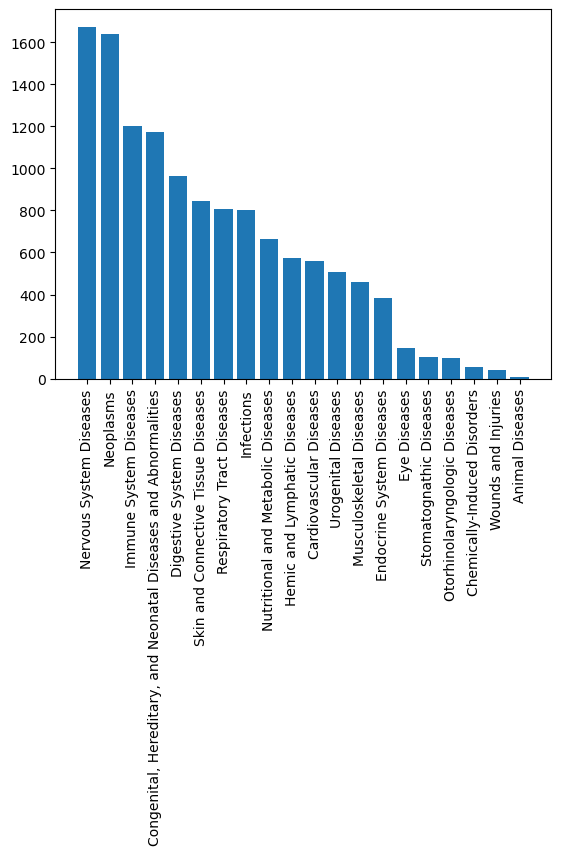

In [524]:
from collections import Counter

counts = Counter(root_terms)
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

plt.bar([x[0] for x in sorted_counts[:]], [x[1] for x in sorted_counts[:]])
plt.xticks(rotation=90)

In [33]:
# exclude symbols if they are tranlated to a root term
# We do this because different symbols might have the same term
# and we want to exclude root terms ! ! !
# check if there are root terms which have different symbols
# if all root terms are unique - no need to remove symbols
quality_check = False
for root_term in root_terms:
    if len([mesh_term_2_symbols[root_term]]) > 1:
        logging.info(
            f"Root term {root_term} has different symbols"
            f" {mesh_term_2_symbols[root_term]}"
        )
        quality_check = True

if quality_check:
    logging.info("Quality check failed. Root terms not unique.")
    exit()

In [540]:
df_data_info[df_data_info["dsaid"] == "DSA00001"]["organism"].values[0]

'Mus musculus'

### c.3 Branch MeSH Terms

In [647]:
# variables
# MeSH Hierarchical level we are interested in
level = 3
level_split = level * 4 + 3

# iterate through all symbols
branch_terms = set()
list_branch_terms = list()
n_terms_below_level = 0
n_terms_absolute_leaf = 0
for s in mesh_symbol_2_term.keys():
    # if the symbol is below the hierarchical level we are interested in
    if filter_criteria(s) and len(s) >= level_split:
        branch_terms.add(mesh_symbol_2_term[s])
        list_branch_terms.append(mesh_symbol_2_term[s])
        n_terms_below_level += 1

    # if the symbol is above the hierarchical level we are interested in
    # we can still add it if it is an "absolute" leaf meaning that it
    # has no children
    elif filter_criteria(s) and (len(s) < level_split):
        # check if it has children but exclude root term
        children = [k for k in mesh_symbol_2_term.keys() if k.startswith(s) & (k != s)]
        if len(children) == 0 and len(s) >= 4:
            branch_terms.add(mesh_symbol_2_term[s])
            list_branch_terms.append(mesh_symbol_2_term[s])
            n_terms_absolute_leaf += 1
        else:
            continue  # if it has children we do not add it

assert len(branch_terms) == len(set(list_branch_terms)), "Err Something went wrong :("

logging.info(
    f"Nº of found terms: {len(list_branch_terms)} of which unique {len(branch_terms)}"
)
logging.info(
    f"Nº of terms below level: {n_terms_below_level} Nº of absolute leaf terms: {n_terms_absolute_leaf}"
)

2024-01-21 19:13:15,307 - INFO - Nº of found terms: 10885 of which unique 4161
2024-01-21 19:13:15,308 - INFO - Nº of terms below level: 9826 Nº of absolute leaf terms: 1059


In [648]:
# store rows for dataframe
counts = dict()

# loop through different branch terms
for term in tqdm(branch_terms):
    # get dsaids with term
    found_dsaids = get_dsaids_with_term(
        term_interest=term,
        dsaids=list(disease_id_2_mesh.keys()),
        disease_id_2_mesh=disease_id_2_mesh,
    )

    if len(found_dsaids) > 0:
        # quick check
        assert len(found_dsaids) == len(
            set(found_dsaids)
        ), "Err Something went wrong :( dsaids are not unique"

        # get number of signatures
        n_signatures = len(found_dsaids)
        counts[term] = n_signatures

100%|██████████| 4161/4161 [02:02<00:00, 34.04it/s]


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'Dementia'),
  Text(1, 0, 'Basal Ganglia Diseases'),
  Text(2, 0, 'Dyskinesias'),
  Text(3, 0, 'Chorea'),
  Text(4, 0, 'Huntington Disease'),
  Text(5, 0, 'Colonic Diseases'),
  Text(6, 0, 'Carcinoma'),
  Text(7, 0, 'Inflammatory Bowel Diseases'),
  Text(8, 0, 'Urologic Diseases'),
  Text(9, 0, 'Neuroectodermal Tumors'),
  Text(10, 0, 'Kidney Diseases'),
  Text(11, 0, 'Diabetes Mellitus'),
  Text(12, 0, 'Respiratory Hypersensitivity'),
  Text(13, 0, 'Adenocarcinoma'),
  Text(14, 0, 'Colitis'),
  Text(15, 0, 'Alzheimer Disease'),
  Text(16, 0, 'Asthma'),
  Text(17, 0, 'Gastrointestinal Neoplasms'),
  Text(18, 0, 'Influenza, Human'),
  Text(19, 0, 'Orthomyxoviridae Infections'),
  Text(20, 0, 'Leukemia, Myeloid'),
  Text(21, 0, 'Synucleinopathies'),
  Text(22, 0, 'Parkinsonian Disorders'),
  Text(23, 0, 'Mu

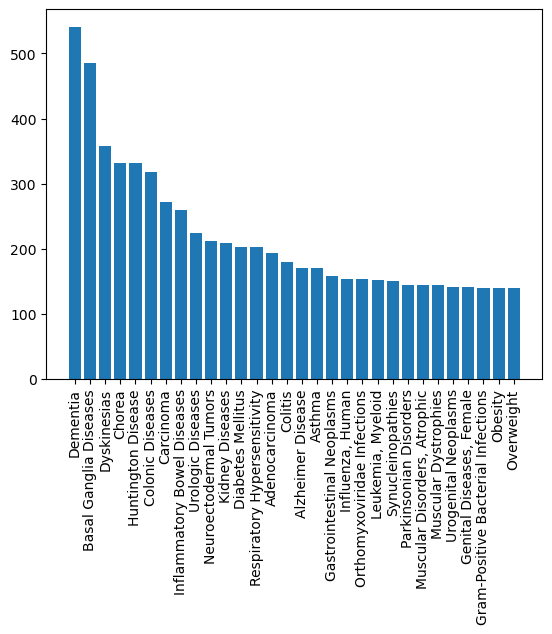

In [649]:
N_TOP = 30
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

plt.bar([x[0] for x in sorted_counts[:N_TOP]], [x[1] for x in sorted_counts[:N_TOP]])
plt.xticks(rotation=90)

### c.4 Leaf MeSH Terms

In [659]:
def find_longest_string(strings):
    """Find the longest string in a list of strings"""
    longest_string = ""
    for s in strings:
        if len(s) > len(longest_string):
            longest_string = s
    return longest_string


# create list of root symbols
total_root_symbols = set(
    [s[:3] for s in mesh_symbol_2_term.keys() if filter_criteria(s)]
)

leaf_symbols_all = list()  # will be a list of lists

for k in disease_id_2_mesh.keys():
    leaf_symbols_disease = list()
    #  if disease_id has MeSH symbols
    if disease_id_2_mesh[k]["symbols"] is not None:
        symbols = disease_id_2_mesh[k]["symbols"]
        # iterate through different root terms
        for specific_root_symbol in total_root_symbols:
            symbols_for_root = [
                s for s in symbols if s.startswith(specific_root_symbol)
            ]
            if len(symbols) > 0:
                longest_length_symbol = find_longest_string(symbols_for_root)
                if len(longest_length_symbol) > 7:  # to exclude root terms!
                    # and second root terms!

                    leaf_symbols_disease.extend(
                        [
                            t
                            for t in symbols_for_root
                            if len(t) == len(longest_length_symbol)
                        ]
                    )
        leaf_symbols_all.append(leaf_symbols_disease)
# root symbols all will be a list of lists - we do this because
# sometimes different symbols have the same term - we will translate the
# list of set terms to avoid over-estimation
# this is not likely to happen because this problem occurs when dealing
# with quite different symbols - but it is good practice anyways
leaf_terms = list()

# iterate through sublist of leaf symbols
for leaf_symbols_sublist in leaf_symbols_all:
    terms = set()
    # iterate through root symbols
    for leaf_symbol in leaf_symbols_sublist:
        terms.add(mesh_symbol_2_term[leaf_symbol])
    # append after looping though all root symbols
    # the set of terms to the root terms list
    leaf_terms.extend(list(terms))


leaf_symbols_flat = [e for sublist in leaf_symbols_all for e in sublist]

logging.info(
    f"Variation of longest terms:  {min([len(s) for s in leaf_symbols_flat])} to {max([len(s) for s in leaf_symbols_flat])}"
)

2024-01-21 19:43:50,616 - INFO - Variation of longest terms:  11 to 39


In [656]:
len(
    [k for k in disease_id_2_mesh.keys() if disease_id_2_mesh[k]["symbols"] is not None]
)

10306

In [660]:
len(leaf_symbols_all)

10306

Text(0.5, 1.0, 'Top 30 terms from total nº of Leaf terms 16148')

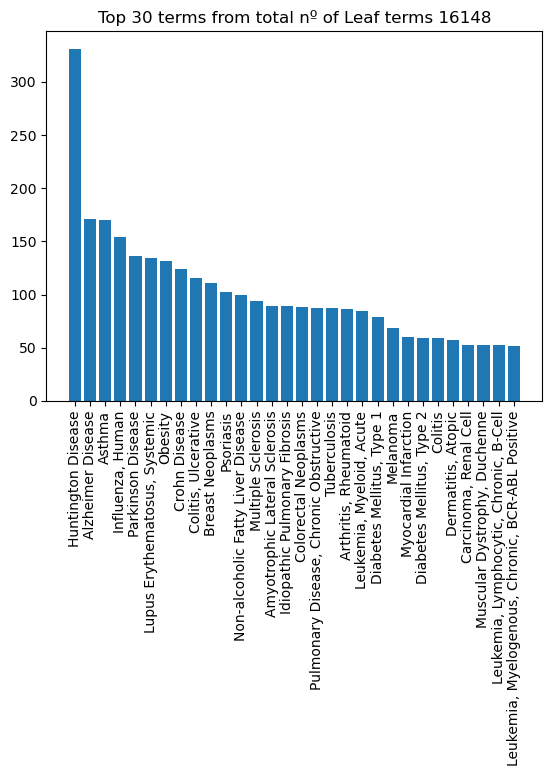

In [661]:
from collections import Counter

N = 30
counts = Counter(leaf_terms)
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

plt.bar([x[0] for x in sorted_counts[:N]], [x[1] for x in sorted_counts[:N]])
plt.xticks(rotation=90)
plt.title(f"Top {N} terms from total nº of Leaf terms {len(leaf_symbols_flat)}")

### c.5 Specific Branch MeSH Terms

In [650]:
# specific leaf symbol
specific_leaf_symbol = "C04"

# variables
# MeSH Hierarchical level we are interested in
level = 1
level_split = level * 4 + 3

# iterate through all symbols
branch_terms = set()
list_branch_terms = list()
n_terms_below_level = 0
n_terms_absolute_leaf = 0
for s in mesh_symbol_2_term.keys():
    # if the symbol is below the hierarchical level we are interested in
    if (
        filter_criteria(s)
        and s.startswith(specific_leaf_symbol)
        and len(s) >= level_split
    ):
        branch_terms.add(mesh_symbol_2_term[s])
        list_branch_terms.append(mesh_symbol_2_term[s])
        n_terms_below_level += 1

    # if the symbol is above the hierarchical level we are interested in
    # we can still add it if it is an "absolute" leaf meaning that it
    # has no children
    elif filter_criteria(s) and (len(s) < level_split):
        # check if it has children but exclude root term
        children = [k for k in mesh_symbol_2_term.keys() if k.startswith(s) & (k != s)]
        if len(children) == 0 and len(s) >= 4:
            branch_terms.add(mesh_symbol_2_term[s])
            list_branch_terms.append(mesh_symbol_2_term[s])
            n_terms_absolute_leaf += 1
        else:
            continue  # if it has children we do not add it

assert len(branch_terms) == len(set(list_branch_terms)), "Err Something went wrong :("

logging.info(
    f"Nº of found terms: {len(list_branch_terms)} of which unique {len(branch_terms)}"
)
logging.info(
    f"Nº of terms below level: {n_terms_below_level} Nº of absolute leaf terms: {n_terms_absolute_leaf}"
)

2024-01-21 19:21:44,252 - INFO - Nº of found terms: 1055 of which unique 697
2024-01-21 19:21:44,252 - INFO - Nº of terms below level: 1055 Nº of absolute leaf terms: 0


In [651]:
# store rows for dataframe
counts = dict()

# loop through different branch terms
for term in tqdm(branch_terms):
    # get dsaids with term
    found_dsaids = get_dsaids_with_term(
        term_interest=term,
        dsaids=list(disease_id_2_mesh.keys()),
        disease_id_2_mesh=disease_id_2_mesh,
    )

    if len(found_dsaids) > 0:
        # quick check
        assert len(found_dsaids) == len(
            set(found_dsaids)
        ), "Err Something went wrong :( dsaids are not unique"

        # get number of signatures
        n_signatures = len(found_dsaids)
        counts[term] = n_signatures

100%|██████████| 697/697 [00:19<00:00, 36.66it/s]


Text(0.5, 1.0, 'Top 30 terms from total nº of Leaf terms 16148')

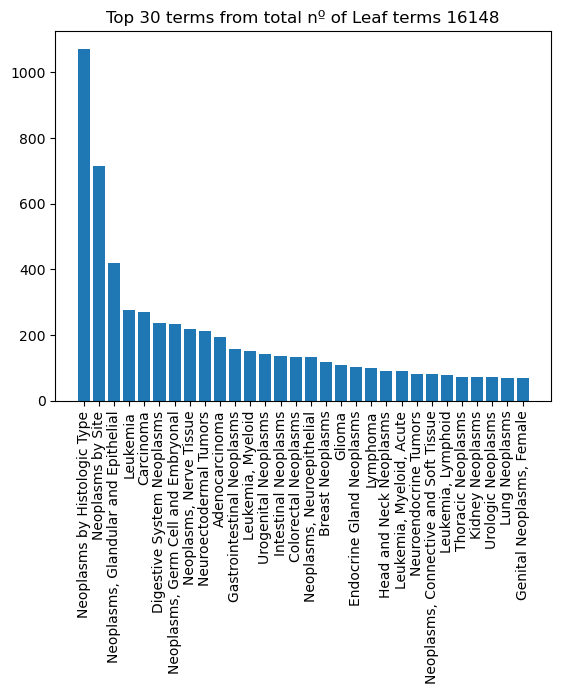

In [652]:
N = 30

sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

plt.bar([x[0] for x in sorted_counts[:N]], [x[1] for x in sorted_counts[:N]])
plt.xticks(rotation=90)
plt.title(f"Top {N} terms from total nº of Leaf terms {len(leaf_symbols_flat)}")

## d. Compute Similarity Metrics

### d.1 Define Signatures - RUN ONCE

In [46]:
"""Compute Similarity Metrics

iLINCS bechmarked several methods for "connecting" transcriptional signatures.
These include Extreme & Weighted correlations, Connectivity Score, Connectivity Map
and correlation based on Log Significance. 

Overall, all six methods performed very well in the bechmark. The decision was made
to use the Extreme Correlation of Signed Log P-values utilizing top 100 up- and down-
regulated genes as it showd best performance. 

Weighted Correlations are also used as they are almost as good but esasier to compute.

Here we implement iLINCS Extreme Correlations.

Structure:
    1. Imports, Variables, Functions
    2. Retrieve Data & Compute Extreme Signed Significance
    3. Compute Correlation of Extreme Signed Significance
    4. Benchmark Results
"""


# 1. Imports, Variables, Functions
# imports
import scipy.stats as stats, matplotlib.pyplot as plt, seaborn as sns, numpy as np, pandas as pd
import logging
import time, requests
import multiprocessing
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map  # For easy tqdm integration with Pool
import h5py, os, sys

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


# variables
output_path = os.path.join("..", "data", "DiSignAtlas", "ess.h5")
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
)


# functions
def compute_signed_significance(dsaid):
    """
    Calculate signed significance for each gene in the signature.
    Args:
    - dsaid: str

    Returns:
    - signed_significance: list of tupples
    - d_signed_significance: list of tupples
    """
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )

    df = pd.read_csv(data_path, sep="\t")

    signed_significance = list()
    de_values = list()
    for index, row in df.iterrows():
        # Handle cases where AdjPValue is 0
        # or nan values
        if (row["AdjPValue"] != 0) and (not np.isnan(row["AdjPValue"])):
            sign = np.sign(row["Log2FC"])
            ss = sign * (-np.log10(row["AdjPValue"]))
            signed_significance.append((row["GeneID"], ss))
            de_values.append((row["GeneID"], row["Log2FC"]))

    return signed_significance, de_values


def compute_extreme_signed_significance(signed_significance, k=100):
    """
    Compute Extreme Signed Significance for top & bottom k ss genes, rest
    are assigned value of 0.

    Arguments:
    - signed_significance: list of tupples
        List of tupples [(geneid,ss), ...]
    - k: int()
        Top/Bottom k genes.

    Returns:
    - extreme_signed_significance: list of tupples
        List of gene ids and signed significance
    """
    # sort signed significance by value
    sorted_signed_significance = sorted(
        signed_significance, key=lambda x: x[1], reverse=True
    )

    # get top_bottom values
    top_bottom_genes = [ss[0] for ss in sorted_signed_significance[:k]] + [
        ss[0] for ss in sorted_signed_significance[-k:]
    ]

    # set values for non top/bottom k to 0
    extreme_signed_significance = {
        gene: ss if gene in top_bottom_genes else 0 for gene, ss in signed_significance
    }

    return extreme_signed_significance


def check_microarray_file_path(dsaid):
    """Check Microarray File Path
    Arguments:
        - dsaid: str
    Returns:
        - bool
    """
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )
    return os.path.exists(data_path)


def check_number_of_significant_genes(extreme_signed_significance):
    """Check Number of Significant Genes

    Arguments:
        - extreme_signed_significance (dict): gene_id -> extreme signed significance
    Returns:
        - bool
    """
    values = np.array(list(extreme_signed_significance.values()), dtype=bool)
    if np.sum(values) == 200:
        return True
    else:
        return False


def process_dsaid(dsaid):
    if check_microarray_file_path(dsaid):
        signed_significance, de_values = compute_signed_significance(dsaid)
        extreme_signed_significance = compute_extreme_signed_significance(
            signed_significance
        )

        if check_number_of_significant_genes(extreme_signed_significance):
            return dsaid, extreme_signed_significance

        return dsaid, "Error: Nº of significant genes < 200"
    return dsaid, None


def get_all_significant_genes(disease_id_2_ess):
    """Get All Significant Genes

    Function to retrieve all significant genes from DiSignAtlas.

    Arguments:
        disease_id_2_ess (dict): Dictionary of disease ids to extreme signed significance.

    Returns:
        all_significant_genes (list): List of all significant genes.
    """
    all_significant_genes = set()
    for dsaid, ess in tqdm(disease_id_2_ess.items()):
        significant_genes = [k for k, v in ess.items() if v != 0]
        # update set
        all_significant_genes.update(significant_genes)

    # sort genes
    all_significant_genes = list(all_significant_genes)
    all_significant_genes.sort()

    return all_significant_genes


def estimate_memory_usage(array):
    # Get the size of one array item in bytes
    item_size = array.itemsize

    # Get the total number of elements in the array
    total_elements = array.size

    # Calculate total memory usage
    memory_usage_bytes = item_size * total_elements

    # Convert to kilobytes (optional)
    memory_usage_mb = memory_usage_bytes / 1024 / 1024

    return memory_usage_bytes, memory_usage_mb

/home/ddalton/miniconda3/envs/disease_sig/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 2. Retrieve Data & Compute Extreme Signed Significance
# retrieve signatures
# disease_id_2_ess = dict()
# for dsaid in tqdm(df_dataset_info["dsaid"].unique()):
#     if check_microarray_file_path(dsaid):
#         signed_significance, de_values = compute_signed_significance(dsaid)
#         extreme_signed_significance = compute_extreme_signed_significance(
#             signed_significance
#         )
#         disease_id_2_ess[dsaid] = extreme_signed_significance

# Using process_map for automatic tqdm integration
results = process_map(
    process_dsaid,
    df_dataset_info["dsaid"].unique(),
    max_workers=multiprocessing.cpu_count(),
)

In [ ]:
disease_id_2_ess = {
    dsaid: ess
    for dsaid, ess in results
    if (ess is not None)
    and (not isinstance(ess, str))  # Assuming error messages are strings
}


failed_dsaid_microarray = [dsaid for dsaid, ess in results if ess is None]
failed_dsaid_n_ess = [
    dsaid for dsaid, ess in results if isinstance(ess, str) and ess.startswith("Error")
]
logging.info(f"Nº of non-microarray datasets: {len(failed_dsaid_microarray)}")
logging.info(f"Nº of failed ESS: {len(failed_dsaid_n_ess)}")


# Aggregating results
# We want to create:
# * list of dsaid
# * list of gene ids
# * list of extreme signed significance in order of gene ids

# list of dsaid (microarray data)
dsaid_microarray = list(disease_id_2_ess.keys())

# list of gene ids
all_significant_genes = get_all_significant_genes(disease_id_2_ess)

# Preallocate the matrix with zeros
num_dsaid = len(dsaid_microarray)
num_genes = len(all_significant_genes)
matrix_ess = np.zeros((num_dsaid, num_genes), dtype=float)

# Populate the matrix
for i, dsaid in enumerate(tqdm(dsaid_microarray)):
    ess_values = disease_id_2_ess[dsaid]
    for j, gene in enumerate(all_significant_genes):
        matrix_ess[i, j] = ess_values.get(gene, 0)

    assert np.sum(matrix_ess[i, :] != 0) == 200, "Error Nº of significant genes != 200"

2024-01-15 11:14:15,535 - INFO - Nº of non-microarray datasets: 328
2024-01-15 11:14:15,536 - INFO - Nº of failed ESS: 56
100%|██████████| 9922/9922 [02:57<00:00, 55.94it/s]


In [ ]:
# estimate size of matrix
memory_bytes, memory_mb = estimate_memory_usage(matrix_ess)
print(f"Memory Usage: {memory_bytes} bytes ({memory_mb} MB)")

# save matrix
with h5py.File(output_path, "w") as f:
    # Create datasets and write data
    f.create_dataset("V", data=matrix_ess)
    f.create_dataset("genes", data=all_significant_genes)
    f.create_dataset("id", data=dsaid_microarray)

    # Adding attributes (metadata)
    f["V"].attrs[
        "description"
    ] = "Matrix of values for extreme signed significance. Columns are genes, rows are signatures."
    f["genes"].attrs["description"] = "Gene ID "
    f["id"].attrs["description"] = "Disease Signature Atlas ID"

Memory Usage: 5908431936 bytes (5634.719787597656 MB)


### d.2 Validate Sigantures

In [301]:
"""The aim here is to verify if the signatures have been constructed correctly
To do so we will use the following approach:
    a. Compute a set of signatures from scratch
    b. Compare them to the ones saved in the h5 file
    c. If they are the same, we can assume that the signatures have been constructed correctly

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Compute Signatures
    4. Compare Signatures
"""

# 1. Imports, Variables, Functions
# imports
import h5py, os, sys, numpy as np, pandas as pd
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map  # For easy tqdm integration with Pool

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# variables
n_signatures = 100  # number of signatures to compute
input_path = os.path.join("..", "data", "DiSignAtlas", "ess.h5")


# functions
def sort_list_values(labels_1, labels_2, values_2):
    """Sort List Values

    Arguments:
        - labels_1 (list): labels for which we want values
        - labels_2 (list): labels map to values_2
        - values_2 (list): values which map to labels_2

    Returns
        - values_1 (list): values which map to labels_1
    """
    values_1 = list()

    # Create a dictionary for quick label-value mapping
    label_value_map = dict(zip(labels_2, values_2))
    values_1 = []

    # Iterate through labels_1 and map using the dictionary
    for label_1 in labels_1:
        value = label_value_map.get(label_1)
        if value is not None:
            values_1.append(value)
        else:
            # Handle the case where label_1 is not found in labels_2
            # For example, by appending None or raising an error
            values_1.append(None)  # or use `continue` to skip

    return values_1


def get_signatures_of_interest(dsaids):
    """Get Signatures of Interest

    Arguments:
        - dsaids (list): all dataset ids of interest
    Returns:
        - matrix (numpy): signatures
    """
    # get indexes for datasets of interest
    data_path = os.path.join("..", "data", "DiSignAtlas", "ess.h5")
    with h5py.File(data_path, "r") as f:
        all_ids = f["id"][:].astype("<U")

    # index mapping
    index_mapping = {dsaid: np.where(np.isin(all_ids, dsaid))[0] for dsaid in dsaids}

    # check it only finds one index per dsaid
    assert all(
        index_mapping[dsaid].shape[0] == 1 for dsaid in dsaids
    ), "Error: multiple indexes found"

    # re-define as only one value the dictionary
    index_mapping = {k: v[0] for k, v in index_mapping.items()}

    # un-sorted indexes
    unsorted_indexes = [index_mapping[dsaid] for dsaid in dsaids]

    # sorted indexes ascending orde
    sorted_indexes = sorted(index_mapping.values())

    # get vector values
    with h5py.File(data_path, "r") as f:
        signatures_interest = f["V"][sorted_indexes]
        logging.info(f["V"].attrs["description"])

        ids_interest = f["id"][sorted_indexes].astype("<U")
        logging.info(f["id"].attrs["description"])

    # retrieve original order
    sorted_signatures_interest = sort_list_values(
        labels_1=unsorted_indexes, labels_2=sorted_indexes, values_2=signatures_interest
    )
    sorted_ids_interest = sort_list_values(
        labels_1=unsorted_indexes, labels_2=sorted_indexes, values_2=ids_interest
    )

    # check if the re-arranging is correct
    assert np.all(sorted_ids_interest == dsaids), "Error: re-arranging is incorrect"

    logging.info(
        f"Signature vector shape: {np.array(sorted_signatures_interest).shape}"
    )
    return np.array(sorted_signatures_interest)


def compute_signed_significance(dsaid):
    """
    Calculate signed significance for each gene in the signature.
    Args:
    - dsaid: str

    Returns:
    - signed_significance: list of tupples
    - d_signed_significance: list of tupples
    """
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )

    df = pd.read_csv(data_path, sep="\t")

    signed_significance = list()
    de_values = list()
    for index, row in df.iterrows():
        # Handle cases where AdjPValue is 0
        # or nan values
        if (row["AdjPValue"] != 0) and (not np.isnan(row["AdjPValue"])):
            sign = np.sign(row["Log2FC"])
            ss = sign * (-np.log10(row["AdjPValue"]))
            signed_significance.append((row["GeneID"], ss))
            de_values.append((row["GeneID"], row["Log2FC"]))

    return signed_significance, de_values


def compute_extreme_signed_significance(signed_significance, k=100):
    """
    Compute Extreme Signed Significance for top & bottom k ss genes, rest
    are assigned value of 0.

    Arguments:
    - signed_significance: list of tupples
        List of tupples [(geneid,ss), ...]
    - k: int()
        Top/Bottom k genes.

    Returns:
    - extreme_signed_significance: list of tupples
        List of gene ids and signed significance
    """
    # sort signed significance by value
    sorted_signed_significance = sorted(
        signed_significance, key=lambda x: x[1], reverse=True
    )

    # get top_bottom values
    top_bottom_genes = [ss[0] for ss in sorted_signed_significance[:k]] + [
        ss[0] for ss in sorted_signed_significance[-k:]
    ]

    # set values for non top/bottom k to 0
    extreme_signed_significance = {
        gene: ss if gene in top_bottom_genes else 0 for gene, ss in signed_significance
    }

    return extreme_signed_significance


def check_microarray_file_path(dsaid):
    """Check Microarray File Path
    Arguments:
        - dsaid: str
    Returns:
        - bool
    """
    data_path = os.path.join(
        "..", "data", "DiSignAtlas", "dsa_diff_download", f"{dsaid}_alldiff.txt"
    )
    return os.path.exists(data_path)


def check_number_of_significant_genes(extreme_signed_significance):
    """Check Number of Significant Genes

    Arguments:
        - extreme_signed_significance (dict): gene_id -> extreme signed significance
    Returns:
        - bool
    """
    values = np.array(list(extreme_signed_significance.values()), dtype=bool)
    if np.sum(values) == 200:
        return True
    else:
        return False


def process_dsaid(dsaid):
    if check_microarray_file_path(dsaid):
        signed_significance, de_values = compute_signed_significance(dsaid)
        extreme_signed_significance = compute_extreme_signed_significance(
            signed_significance
        )

        if check_number_of_significant_genes(extreme_signed_significance):
            return dsaid, extreme_signed_significance

        return dsaid, "Error: Nº of significant genes < 200"
    return dsaid, None


def get_all_significant_genes(disease_id_2_ess):
    """Get All Significant Genes

    Function to retrieve all significant genes from DiSignAtlas.

    Arguments:
        disease_id_2_ess (dict): Dictionary of disease ids to extreme signed significance.

    Returns:
        all_significant_genes (list): List of all significant genes.
    """
    all_significant_genes = set()
    for dsaid, ess in tqdm(disease_id_2_ess.items()):
        significant_genes = [k for k, v in ess.items() if v != 0]
        # update set
        all_significant_genes.update(significant_genes)

    # sort genes
    all_significant_genes = list(all_significant_genes)
    all_significant_genes.sort()

    return all_significant_genes


# 2. Load Data
# get microarray signature dataset ids
with h5py.File(input_path, "r") as f:
    print(f.keys())
    dsaid_microarray = f["id"][:].astype("<U")
    all_significant_genes = f["genes"][:]
# subsample
dsaid_microarray_subsample = random.sample(list(dsaid_microarray), n_signatures)

# get pre-computed signatures (the ones we computed
# in the previous step and saved in h5 file)
precomputed_signatures = get_signatures_of_interest(dsaid_microarray_subsample)

# 3. Compute Signatures
# compute signatures from scratch
results_subsample = process_map(
    process_dsaid,
    dsaid_microarray_subsample,
    max_workers=multiprocessing.cpu_count(),
)

disease_id_2_ess_subsample = {
    dsaid: ess
    for dsaid, ess in results_subsample
    if (ess is not None)
    and (not isinstance(ess, str))  # Assuming error messages are strings
}

logging.info(f"Nº of ESS computed from scratch: {len(disease_id_2_ess_subsample)}")

# Preallocate the matrix with zeros
num_dsaid = len(dsaid_microarray_subsample)
num_genes = len(all_significant_genes)
matrix_ess_subsample = np.zeros((num_dsaid, num_genes), dtype=float)

# Populate the matrix
# iterate through datasets
for i, dsaid in enumerate(tqdm(dsaid_microarray_subsample)):
    ess_values = disease_id_2_ess_subsample[dsaid]

    # iterate through genes
    for j, gene in enumerate(all_significant_genes):
        matrix_ess_subsample[i, j] = ess_values.get(gene, 0)

    assert (
        np.sum(matrix_ess_subsample[i, :] != 0) == 200
    ), "Error Nº of significant genes != 200"

<KeysViewHDF5 ['V', 'genes', 'id']>


2024-01-17 17:40:13,767 - INFO - Matrix of values for extreme signed significance. Columns are genes, rows are signatures.
2024-01-17 17:40:13,773 - INFO - Disease Signature Atlas ID
2024-01-17 17:40:13,780 - INFO - Signature vector shape: (100, 74436)
100%|██████████| 100/100 [00:07<00:00, 13.45it/s]
2024-01-17 17:40:23,276 - INFO - Nº of ESS computed from scratch: 100
100%|██████████| 100/100 [00:01<00:00, 64.88it/s]


In [313]:
# 4. Compare Signatures
if np.all(matrix_ess_subsample == precomputed_signatures):
    logging.info(
        f"Quality Check: Signatures saved in {input_path}\n coincide w/ signatures computed from scratch for a total of {n_signatures} signatures"
    )

2024-01-17 17:43:19,307 - INFO - Quality Check: Signatures saved in ../data/DiSignAtlas/ess.h5
 coincide w/ signatures computed from scratch for a total of 100 signatures


### d.3 Signature Correlation: Example 

In [255]:
"""Signature Correlation: Example

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Compute Signature Correlation
"""

# imports
import h5py, os, sys, logging

# variables
# mesh_symbol_interest = ["C20.111.327"]
mesh_term_interest = "Bulbo-Spinal Atrophy, X-Linked"
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)


# functions
def sort_list_values(labels_1, labels_2, values_2):
    """Sort List Values

    Arguments:
        - labels_1 (list): labels for which we want values
        - labels_2 (list): labels map to values_2
        - values_2 (list): values which map to labels_2

    Returns
        - values_1 (list): values which map to labels_1
    """
    values_1 = list()

    # Create a dictionary for quick label-value mapping
    label_value_map = dict(zip(labels_2, values_2))
    values_1 = []

    # Iterate through labels_1 and map using the dictionary
    for label_1 in labels_1:
        value = label_value_map.get(label_1)
        if value is not None:
            values_1.append(value)
        else:
            # Handle the case where label_1 is not found in labels_2
            # For example, by appending None or raising an error
            values_1.append(None)  # or use `continue` to skip

    return values_1


def get_signatures_of_interest(dsaids):
    """Get Signatures of Interest

    Arguments:
        - dsaids (list): all dataset ids of interest
    Returns:
        - matrix (numpy): signatures
    """
    # get indexes for datasets of interest
    data_path = os.path.join("..", "data", "DiSignAtlas", "ess.h5")
    with h5py.File(data_path, "r") as f:
        all_ids = f["id"][:].astype("<U")

    # index mapping
    index_mapping = {dsaid: np.where(np.isin(all_ids, dsaid))[0] for dsaid in dsaids}

    # check it only finds one index per dsaid
    assert all(
        index_mapping[dsaid].shape[0] == 1 for dsaid in dsaids
    ), "Error: multiple indexes found"

    # re-define as only one value the dictionary
    index_mapping = {k: v[0] for k, v in index_mapping.items()}

    # un-sorted indexes
    unsorted_indexes = [index_mapping[dsaid] for dsaid in dsaids]

    # sorted indexes ascending orde
    sorted_indexes = sorted(index_mapping.values())

    # get vector values
    with h5py.File(data_path, "r") as f:
        signatures_interest = f["V"][sorted_indexes]
        logging.info(f["V"].attrs["description"])

        ids_interest = f["id"][sorted_indexes].astype("<U")
        logging.info(f["id"].attrs["description"])

    # retrieve original order
    sorted_signatures_interest = sort_list_values(
        labels_1=unsorted_indexes, labels_2=sorted_indexes, values_2=signatures_interest
    )
    sorted_ids_interest = sort_list_values(
        labels_1=unsorted_indexes, labels_2=sorted_indexes, values_2=ids_interest
    )

    # check if the re-arranging is correct
    assert np.all(sorted_ids_interest == dsaids), "Error: re-arranging is incorrect"

    logging.info(
        f"Signature vector shape: {np.array(sorted_signatures_interest).shape}"
    )
    return np.array(sorted_signatures_interest)


def compute_pearson_correlation(data_matrix_1, data_matrix_2=None):
    """Compute Pearson Correlation
    Arguments:
        - matrix (numpy): matrix of values
    Returns:
        - correlation_values (list): correlation list
    """
    # Compute correlation matrix
    if data_matrix_2 is not None:
        correlation_matrix = np.corrcoef(data_matrix_1, data_matrix_2)
    else:
        correlation_matrix = np.corrcoef(data_matrix_1)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return correlation_values


# 2. Load Data


with h5py.File(output_path, "r") as f:
    # Read the data
    genes = f["genes"][:].astype("<U")
    dsaid_microarray = f["id"][:].astype("<U")

    # Read the attributes
    logging.info(f["id"].attrs["description"])
    logging.info(f["genes"].attrs["description"])

# load data info
df_info = pd.read_csv(data_info_path)

# get dsaid's of interest

human_dsaids = set(dsaid_microarray) & set(
    df_info[df_info["organism"] == "Homo sapiens"]["dsaid"]
)
dsaids_human = set(succesful_mesh_symbols) & set(human_dsaids)

logging.info(f"Nº of Human Datasets with MeSH terms: {len(dsaids_human)}")

# 3. Compute Signature Correlation

2024-01-17 15:43:13,717 - INFO - Disease Signature Atlas ID
2024-01-17 15:43:13,718 - INFO - Gene ID 
2024-01-17 15:43:13,745 - INFO - Nº of Human Datasets with MeSH terms: 5285


In [256]:
mesh_term_2_symbols["Huntington Disease"]

['C10.228.140.079.545',
 'C10.228.140.380.278',
 'C10.228.662.262.249.750',
 'C10.574.500.497',
 'C16.320.400.430',
 'F03.615.250.400',
 'F03.615.400.390']

In [257]:
mesh_symbol_2_term["F03"]

'Mental Disorders'

In [258]:
dsaids_interest = list()
# iterate through datasets
for dsaid in dsaids_human:
    flag = False
    # iterate through mesh_symbols in datases
    for mesh_symbol in disease_id_2_mesh[dsaid]["symbols"]:
        # iterate through mesh_terms of interest

        for mesh_symbol_interest in mesh_term_2_symbols[mesh_term_interest]:
            # if it finds it break both mesh terms of interest group AND
            # mesh symbols of datasets
            # move on to NEXT dataset ! ! !
            if mesh_symbol.startswith(mesh_symbol_interest):
                dsaids_interest.append(dsaid)
                flag = True
                break
        if flag:
            break


logging.info(
    f"Nº of MeSH symbols of interest for {mesh_term_interest}: {len(dsaids_interest)}"
)

2024-01-17 15:43:14,571 - INFO - Nº of MeSH symbols of interest for Bulbo-Spinal Atrophy, X-Linked: 7


In [259]:
d = 0
for k in dsaids_human:
    if "Huntington Disease" in disease_id_2_mesh[k]["terms"]:
        d += 1
logging.info(f"Nº of d {d}")

2024-01-17 15:43:15,047 - INFO - Nº of d 59


In [260]:
all_symbols = list()
for k in disease_id_2_mesh.keys():
    unique_terms = list(set(disease_id_2_mesh[k]["terms"]))
    all_symbols.extend(unique_terms)
Counter(all_symbols).most_common(10)

[('Huntington Disease', 331),
 ('Alzheimer Disease', 171),
 ('Asthma', 170),
 ('Influenza, Human', 154),
 ('Parkinson Disease', 136),
 ('Lupus Erythematosus, Systemic', 134),
 ('Obesity', 132),
 ('Crohn Disease', 124),
 ('Colitis, Ulcerative', 116),
 ('Sepsis', 114)]

In [261]:
disease_id_2_mesh

{'DSA00001': {'symbols': ['C10.228.140.380.100',
   'C10.574.945.249',
   'F03.615.400.100'],
  'terms': ['Alzheimer Disease', 'Alzheimer Disease', 'Alzheimer Disease']},
 'DSA00002': {'symbols': ['C10.228.140.380.100',
   'C10.574.945.249',
   'F03.615.400.100'],
  'terms': ['Alzheimer Disease', 'Alzheimer Disease', 'Alzheimer Disease']},
 'DSA00003': {'symbols': ['C10.228.140.380.100',
   'C10.574.945.249',
   'F03.615.400.100'],
  'terms': ['Alzheimer Disease', 'Alzheimer Disease', 'Alzheimer Disease']},
 'DSA00004': {'symbols': ['C04.557.465.625.600.725',
   'C04.557.470.670.725',
   'C04.557.580.625.600.725',
   'C04.588.364.818.760',
   'C11.270.862',
   'C11.319.475.760',
   'C11.768.717.760'],
  'terms': ['Retinoblastoma',
   'Retinoblastoma',
   'Retinoblastoma',
   'Retinoblastoma',
   'Retinoblastoma',
   'Retinoblastoma',
   'Retinoblastoma']},
 'DSA00005': {'symbols': ['C05.651.534.500.500',
   'C05.651.662.750',
   'C10.574.500.547',
   'C10.668.491.175.500.500',
   'C10.

In [262]:
all_symbols = list()
for k in human_dsaids:
    unique_terms = list(set(disease_id_2_mesh[k]["terms"]))
    all_symbols.extend(unique_terms)
Counter(all_symbols).most_common(10)

[('Asthma', 159),
 ('Lupus Erythematosus, Systemic', 127),
 ('Crohn Disease', 114),
 ('Influenza, Human', 112),
 ('Alzheimer Disease', 107),
 ('Colitis, Ulcerative', 107),
 ('Parkinson Disease', 106),
 ('Schizophrenia', 92),
 ('Psoriasis', 85),
 ('Breast Neoplasms', 83)]

In [263]:
df_data_info[df_data_info["disease"] == "Huntington Disease"]

Empty DataFrame
Columns: [dsaid, accession, platform, deg_count, disease, diseaseid, tissue, data_source, library_strategy, organism, control_case_sample_count, definition]
Index: []

In [264]:
Counter(all_symbols)

Counter({'Asthma': 159,
         'Lupus Erythematosus, Systemic': 127,
         'Crohn Disease': 114,
         'Influenza, Human': 112,
         'Alzheimer Disease': 107,
         'Colitis, Ulcerative': 107,
         'Parkinson Disease': 106,
         'Schizophrenia': 92,
         'Psoriasis': 85,
         'Breast Neoplasms': 83,
         'Pulmonary Disease, Chronic Obstructive': 83,
         'Arthritis, Rheumatoid': 82,
         'Multiple Sclerosis': 82,
         'Idiopathic Pulmonary Fibrosis': 70,
         'Leukemia, Myeloid, Acute': 69,
         'Colorectal Neoplasms': 69,
         'Amyotrophic Lateral Sclerosis': 65,
         'Diabetes Mellitus, Type 1': 60,
         'Huntington Disease': 59,
         'Tuberculosis': 59,
         'Sepsis': 57,
         'Melanoma': 52,
         'Autism Spectrum Disorder': 50,
         'Carcinoma, Renal Cell': 48,
         'Glioblastoma': 48,
         'Myelodysplastic Syndromes': 47,
         'Bipolar Disorder': 46,
         'Leukemia, Myelogenous, 

In [267]:
matrix_signatures_interest = get_signatures_of_interest(dsaids_interest)

2024-01-17 15:43:19,584 - INFO - Matrix of values for extreme signed significance. Columns are genes, rows are signatures.
2024-01-17 15:43:19,589 - INFO - Disease Signature Atlas ID
2024-01-17 15:43:19,599 - INFO - Signature vector shape: (7, 74436)


In [268]:
def get_diff_dsaids(dsaids, dsaids_human):
    """Get human dataset ids which are different
    Arguments:
        - dsaids_human (list): dsaids of interest
        - dsaids (list): dsaids which are human
    Returns:
        - dsaids _diff_subsample (list): same nº as dsaids of interest,
        but different ones
    """
    import random

    N = len(dsaids)
    dsaids_diff = list(set(dsaids_human) - set(dsaids))
    dsaids_diff_subsample = random.sample(
        dsaids_diff,
        k=N,
    )
    logging.info(f"Sampled {len(dsaids_diff_subsample)} random different dsaids")
    return dsaids_diff_subsample


dsaids_diff = get_diff_dsaids(dsaids=dsaids_interest, dsaids_human=dsaids_human)
matrix_signatures_diff = get_signatures_of_interest(dsaids_diff)

2024-01-17 15:43:21,058 - INFO - Sampled 7 random different dsaids
2024-01-17 15:43:21,302 - INFO - Matrix of values for extreme signed significance. Columns are genes, rows are signatures.
2024-01-17 15:43:21,309 - INFO - Disease Signature Atlas ID
2024-01-17 15:43:21,311 - INFO - Signature vector shape: (7, 74436)


In [269]:
set(dsaids_diff) & set(dsaids_interest)

set()

In [270]:
same_term_correlations = compute_pearson_correlation(
    data_matrix_1=matrix_signatures_interest, data_matrix_2=None
)

diff_term_correlations = compute_pearson_correlation(
    data_matrix_1=matrix_signatures_interest, data_matrix_2=matrix_signatures_diff
)

In [271]:
len(same_term_correlations)

21

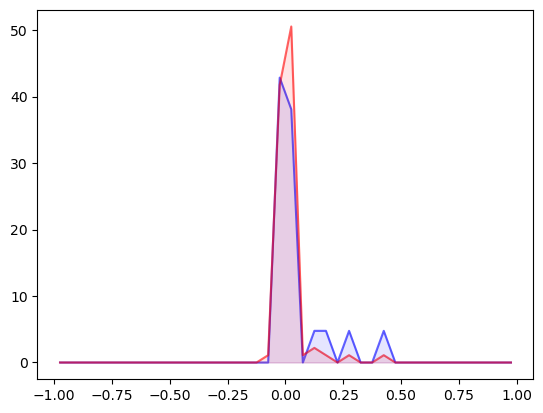

In [272]:
# Define bin width and range
bin_width = 0.05  # Adjust as needed
bin_range = (-1, 1)  # Adjust as needed
bins = np.arange(bin_range[0], bin_range[1] + bin_width, bin_width)


# Calculate histograms and convert to percentages
counts_same, _ = np.histogram(same_term_correlations, bins=bins)
counts_diff, _ = np.histogram(diff_term_correlations, bins=bins)
percent_same = counts_same * 100 / counts_same.sum()
percent_diff = counts_diff * 100 / counts_diff.sum()

# Calculate bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Plot lines and fill area under the lines
plt.plot(bin_centers, percent_same, color="blue", alpha=0.6, zorder=3)
plt.plot(bin_centers, percent_diff, color="red", alpha=0.6, zorder=3)
plt.fill_between(bin_centers, percent_same, color="blue", alpha=0.1, zorder=3)
plt.fill_between(bin_centers, percent_diff, color="red", alpha=0.1, zorder=3)

In [251]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming same_term_correlations and diff_term_correlations are your datasets
data = [same_term_correlations, diff_term_correlations]

# Create a violin plot
plt.figure(figsize=(10, 6))  # Adjust the size as needed
sns.violinplot(data=data, palette=["blue", "red"], inner="quartile")

# Customize the plot (optional)
plt.title("Violin Plot of Correlations")  # Add a title
plt.xticks([0, 1], ["Same Term", "Different Term"])  # Set x-tick labels
plt.xlabel("Term Type")  # Label for the x-axis
plt.ylabel("Correlation Values")  # Label for the y-axis

# Show the plot
plt.show()

In [ ]:
# How many signatures do we have?
total_disease_ids = df_info["dsaid"].nunique()
failed_dsaid_microarray = [dsaid for dsaid, ess in results if ess is None]
failed_dsaid_n_ess = [
    dsaid for dsaid, ess in results if isinstance(ess, str) and ess.startswith("Error")
]
human_dsaids = set(dsaid_microarray) & set(
    df_info[df_info["organism"] == "Homo sapiens"]["dsaid"]
)
succesful_mesh_symbols = [
    k for k in disease_id_2_mesh if (len(disease_id_2_mesh[k]["symbols"]) > 0)
]

mesh_dsaids = set(succesful_mesh_symbols) & set(human_dsaids)


logging.info(f"Nº of total signatures: {total_disease_ids}")
logging.info(
    f"Nº of microarray datasets: {total_disease_ids-len(failed_dsaid_microarray)}"
)
logging.info(
    f"Nº of microarray datasets for which we can build ESS: {total_disease_ids-len(failed_dsaid_n_ess)-len(failed_dsaid_microarray)}"
)
logging.info(f". . . of which are human . . . {len(human_dsaids)}")
logging.info(f". . . of which we can map MeSH terms {len(mesh_dsaids)}")

2024-01-15 17:16:30,169 - INFO - Nº of total signatures: 10306
2024-01-15 17:16:30,170 - INFO - Nº of microarray datasets: 9978
2024-01-15 17:16:30,170 - INFO - Nº of microarray datasets for which we can build ESS: 9922
2024-01-15 17:16:30,170 - INFO - . . . of which are human . . . 6910
2024-01-15 17:16:30,170 - INFO - . . . of which we can map MeSH terms 5275


### d.4 Signature Correlation: All - RUN ONCE

In [274]:
"""Signature Correlation: All

Here we will compute the correlation between ALL signatures ONCE ! ! !
This will accelerate future computations

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Compute Signature Correlation
"""

# imports
import h5py, os, sys, logging

# variables
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)
output_path_correlation = os.path.join("..", "data", "DiSignAtlas", "correlation.h5")


# functions
def sort_list_values(labels_1, labels_2, values_2):
    """Sort List Values

    Arguments:
        - labels_1 (list): labels for which we want values
        - labels_2 (list): labels map to values_2
        - values_2 (list): values which map to labels_2

    Returns
        - values_1 (list): values which map to labels_1
    """
    values_1 = list()

    # Create a dictionary for quick label-value mapping
    label_value_map = dict(zip(labels_2, values_2))
    values_1 = []

    # Iterate through labels_1 and map using the dictionary
    for label_1 in labels_1:
        value = label_value_map.get(label_1)
        if value is not None:
            values_1.append(value)
        else:
            # Handle the case where label_1 is not found in labels_2
            # For example, by appending None or raising an error
            values_1.append(None)  # or use `continue` to skip

    return values_1


def get_signatures_of_interest(dsaids):
    """Get Signatures of Interest

    Arguments:
        - dsaids (list): all dataset ids of interest
    Returns:
        - matrix (numpy): signatures
    """
    # get indexes for datasets of interest
    data_path = os.path.join("..", "data", "DiSignAtlas", "ess.h5")
    with h5py.File(data_path, "r") as f:
        all_ids = f["id"][:].astype("<U")

    # index mapping
    index_mapping = {dsaid: np.where(np.isin(all_ids, dsaid))[0] for dsaid in dsaids}

    # check it only finds one index per dsaid
    assert all(
        index_mapping[dsaid].shape[0] == 1 for dsaid in dsaids
    ), "Error: multiple indexes found"

    # re-define as only one value the dictionary
    index_mapping = {k: v[0] for k, v in index_mapping.items()}

    # un-sorted indexes
    unsorted_indexes = [index_mapping[dsaid] for dsaid in dsaids]

    # sorted indexes ascending orde
    sorted_indexes = sorted(index_mapping.values())

    # get vector values
    with h5py.File(data_path, "r") as f:
        signatures_interest = f["V"][sorted_indexes]
        logging.info(f["V"].attrs["description"])

        ids_interest = f["id"][sorted_indexes].astype("<U")
        logging.info(f["id"].attrs["description"])

    # retrieve original order
    sorted_signatures_interest = sort_list_values(
        labels_1=unsorted_indexes, labels_2=sorted_indexes, values_2=signatures_interest
    )
    sorted_ids_interest = sort_list_values(
        labels_1=unsorted_indexes, labels_2=sorted_indexes, values_2=ids_interest
    )

    # check if the re-arranging is correct
    assert np.all(sorted_ids_interest == dsaids), "Error: re-arranging is incorrect"

    logging.info(
        f"Signature vector shape: {np.array(sorted_signatures_interest).shape}"
    )
    return np.array(sorted_signatures_interest)


def compute_pearson_correlation(data_matrix_1, data_matrix_2=None):
    """Compute Pearson Correlation
    Arguments:
        - matrix (numpy): matrix of values
    Returns:
        - correlation_values (list): correlation list
    """
    # Compute correlation matrix
    if data_matrix_2 is not None:
        correlation_matrix = np.corrcoef(data_matrix_1, data_matrix_2)
    else:
        correlation_matrix = np.corrcoef(data_matrix_1)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return correlation_values


# 2. Load Data

# load all data
with h5py.File(output_path, "r") as f:
    # Read the data
    all_genes = f["genes"][:].astype("<U")
    all_signatures = f["V"][:]
    all_dsaid_microarray = f["id"][:].astype("<U")

    # Read the attributes
    logging.info(f["id"].attrs["description"])
    logging.info(f["genes"].attrs["description"])
    logging.info(f["V"].attrs["description"])

2024-01-17 16:26:11,976 - INFO - Disease Signature Atlas ID
2024-01-17 16:26:11,977 - INFO - Gene ID 
2024-01-17 16:26:11,977 - INFO - Matrix of values for extreme signed significance. Columns are genes, rows are signatures.


In [275]:
all_corelation_values = np.corrcoef(all_signatures)

In [323]:
# Save matrix of all correlation values

with h5py.File(output_path_correlation, "w") as f:
    f.create_dataset("V", data=all_corelation_values, dtype=np.float64)
    f["V"].attrs["description"] = "Correlation matrix of all signatures"

    f.create_dataset("id", data=np.array(all_dsaid_microarray, dtype="S"))
    f["id"].attrs["description"] = "Dataset IDs of all signatures"

In [387]:
def get_correlation_values(
    correlation_matrix, all_dsaid_microarray, dsaids_1, same=True
):
    """Get Correlation Values From Matrix
    It load pre-computed correlation values and retrieve them.
    We can either retrieve the correlation values between one set of dataset
    ids (dsaids_1) or between two sets of dataset ids (dsaids_1 and dsaids_2)

    Arguments:
        correlation_matrix (numpy): correlation matrix of all signatures
        all_dsaid_microarray (list): all dataset ids
        dsaids_1 (list): dataset ids of interest
        same (bool): dataset ids of interest against
        themselves (True) or against rest (False)

    Returns:
        correlation_values (list): correlation values
    """

    # Map dataset ids to indexes
    idxs_1 = np.where(np.isin(all_dsaid_microarray, dsaids_1))[0]

    # dsaids_1 against themselves
    # we want to retrieve the upper triangular part of the correlation matrix !
    if same:
        correlation_values_matrix = correlation_matrix[np.ix_(idxs_1, idxs_1)]
        lower_diagonal_indexes = np.tril_indices(len(idxs_1), k=-1)
        correlation_values = correlation_values_matrix[lower_diagonal_indexes]

        logging.info(
            f"{len(correlation_values)} correlation values for {len(idxs_1)} datasets retrieved from correlation matrix"
        )
    # dsaids_1 against rest

    else:
        # idxs_2 = np.where(np.isin(all_dsaid_microarray, dsaids_2))[0]
        idxs_2 = np.where(~np.isin(all_dsaid_microarray, dsaids_1))[0]
        correlation_values_matrix = correlation_matrix[np.ix_(idxs_1, idxs_2)]
        correlation_values = correlation_values_matrix.flatten()

        logging.info(
            f"{len(correlation_values)} correlation values for {len(idxs_1)} vs {len(idxs_2)} datasets retrieved from correlation matrix"
        )

    return correlation_values

In [367]:
# variables
path_correlation = os.path.join("..", "data", "DiSignAtlas", "correlation.h5")

# open h5 file
with h5py.File(path_correlation, "r") as f:
    # Read the data
    all_dsaid_microarray = f["id"][:].astype("<U")
    correlation_matrix = f["V"][:]
    # Read the attributes
    logging.info(f["id"].attrs["description"])
    logging.info(f["V"].attrs["description"])

2024-01-18 14:52:47,332 - INFO - Dataset IDs of all signatures
2024-01-18 14:52:47,332 - INFO - Correlation matrix of all signatures
2024-01-18 14:52:47,334 - INFO - 190 correlation values for 20 datasets retrieved from correlation matrix


In [371]:
# compute same correlation values
same_correlation_values = get_correlation_values(
    correlation_matrix,
    all_dsaid_microarray,
    dsaids_1=list(dsaids_human)[:20],
    same=True,
)

# compute different correlation values
diff_correlation_values = get_correlation_values(
    correlation_matrix,
    all_dsaid_microarray,
    dsaids_1=list(dsaids_human)[:20],
    same=False,
)

2024-01-18 14:56:41,899 - INFO - 190 correlation values for 20 datasets retrieved from correlation matrix
2024-01-18 14:56:41,902 - INFO - 198040 correlation values for 20 vs 9902 datasets retrieved from correlation matrix


In [ ]:
# load data info
df_info = pd.read_csv(data_info_path)

# get dsaid's of interest

human_dsaids = set(dsaid_microarray) & set(
    df_info[df_info["organism"] == "Homo sapiens"]["dsaid"]
)
dsaids_human = set(succesful_mesh_symbols) & set(human_dsaids)

logging.info(f"Nº of Human Datasets with MeSH terms: {len(dsaids_human)}")

### d.5 Plot Signature Correlation

2024-01-18 19:13:27,931 - INFO - Dataset IDs of all signatures
2024-01-18 19:13:27,932 - INFO - Correlation matrix of all signatures
2024-01-18 19:13:27,946 - INFO - [('Neoplasms', 1216), ('Immune System Diseases', 1011), ('Nervous System Diseases', 939), ('Skin and Connective Tissue Diseases', 743), ('Congenital, Hereditary, and Neonatal Diseases and Abnormalities', 676), ('Respiratory Tract Diseases', 624), ('Digestive System Diseases', 621), ('Infections', 546), ('Hemic and Lymphatic Diseases', 448), ('Nutritional and Metabolic Diseases', 418), ('Urogenital Diseases', 385), ('Cardiovascular Diseases', 338), ('Musculoskeletal Diseases', 337), ('Endocrine System Diseases', 294), ('Eye Diseases', 97), ('Stomatognathic Diseases', 83), ('Otorhinolaryngologic Diseases', 80), ('Chemically-Induced Disorders', 31)]
2024-01-18 19:13:28,021 - INFO - Nº of MeSH symbols of interest for Neoplasms: 1216
2024-01-18 19:13:28,038 - INFO - 738720 correlation values for 1216 datasets retrieved from cor

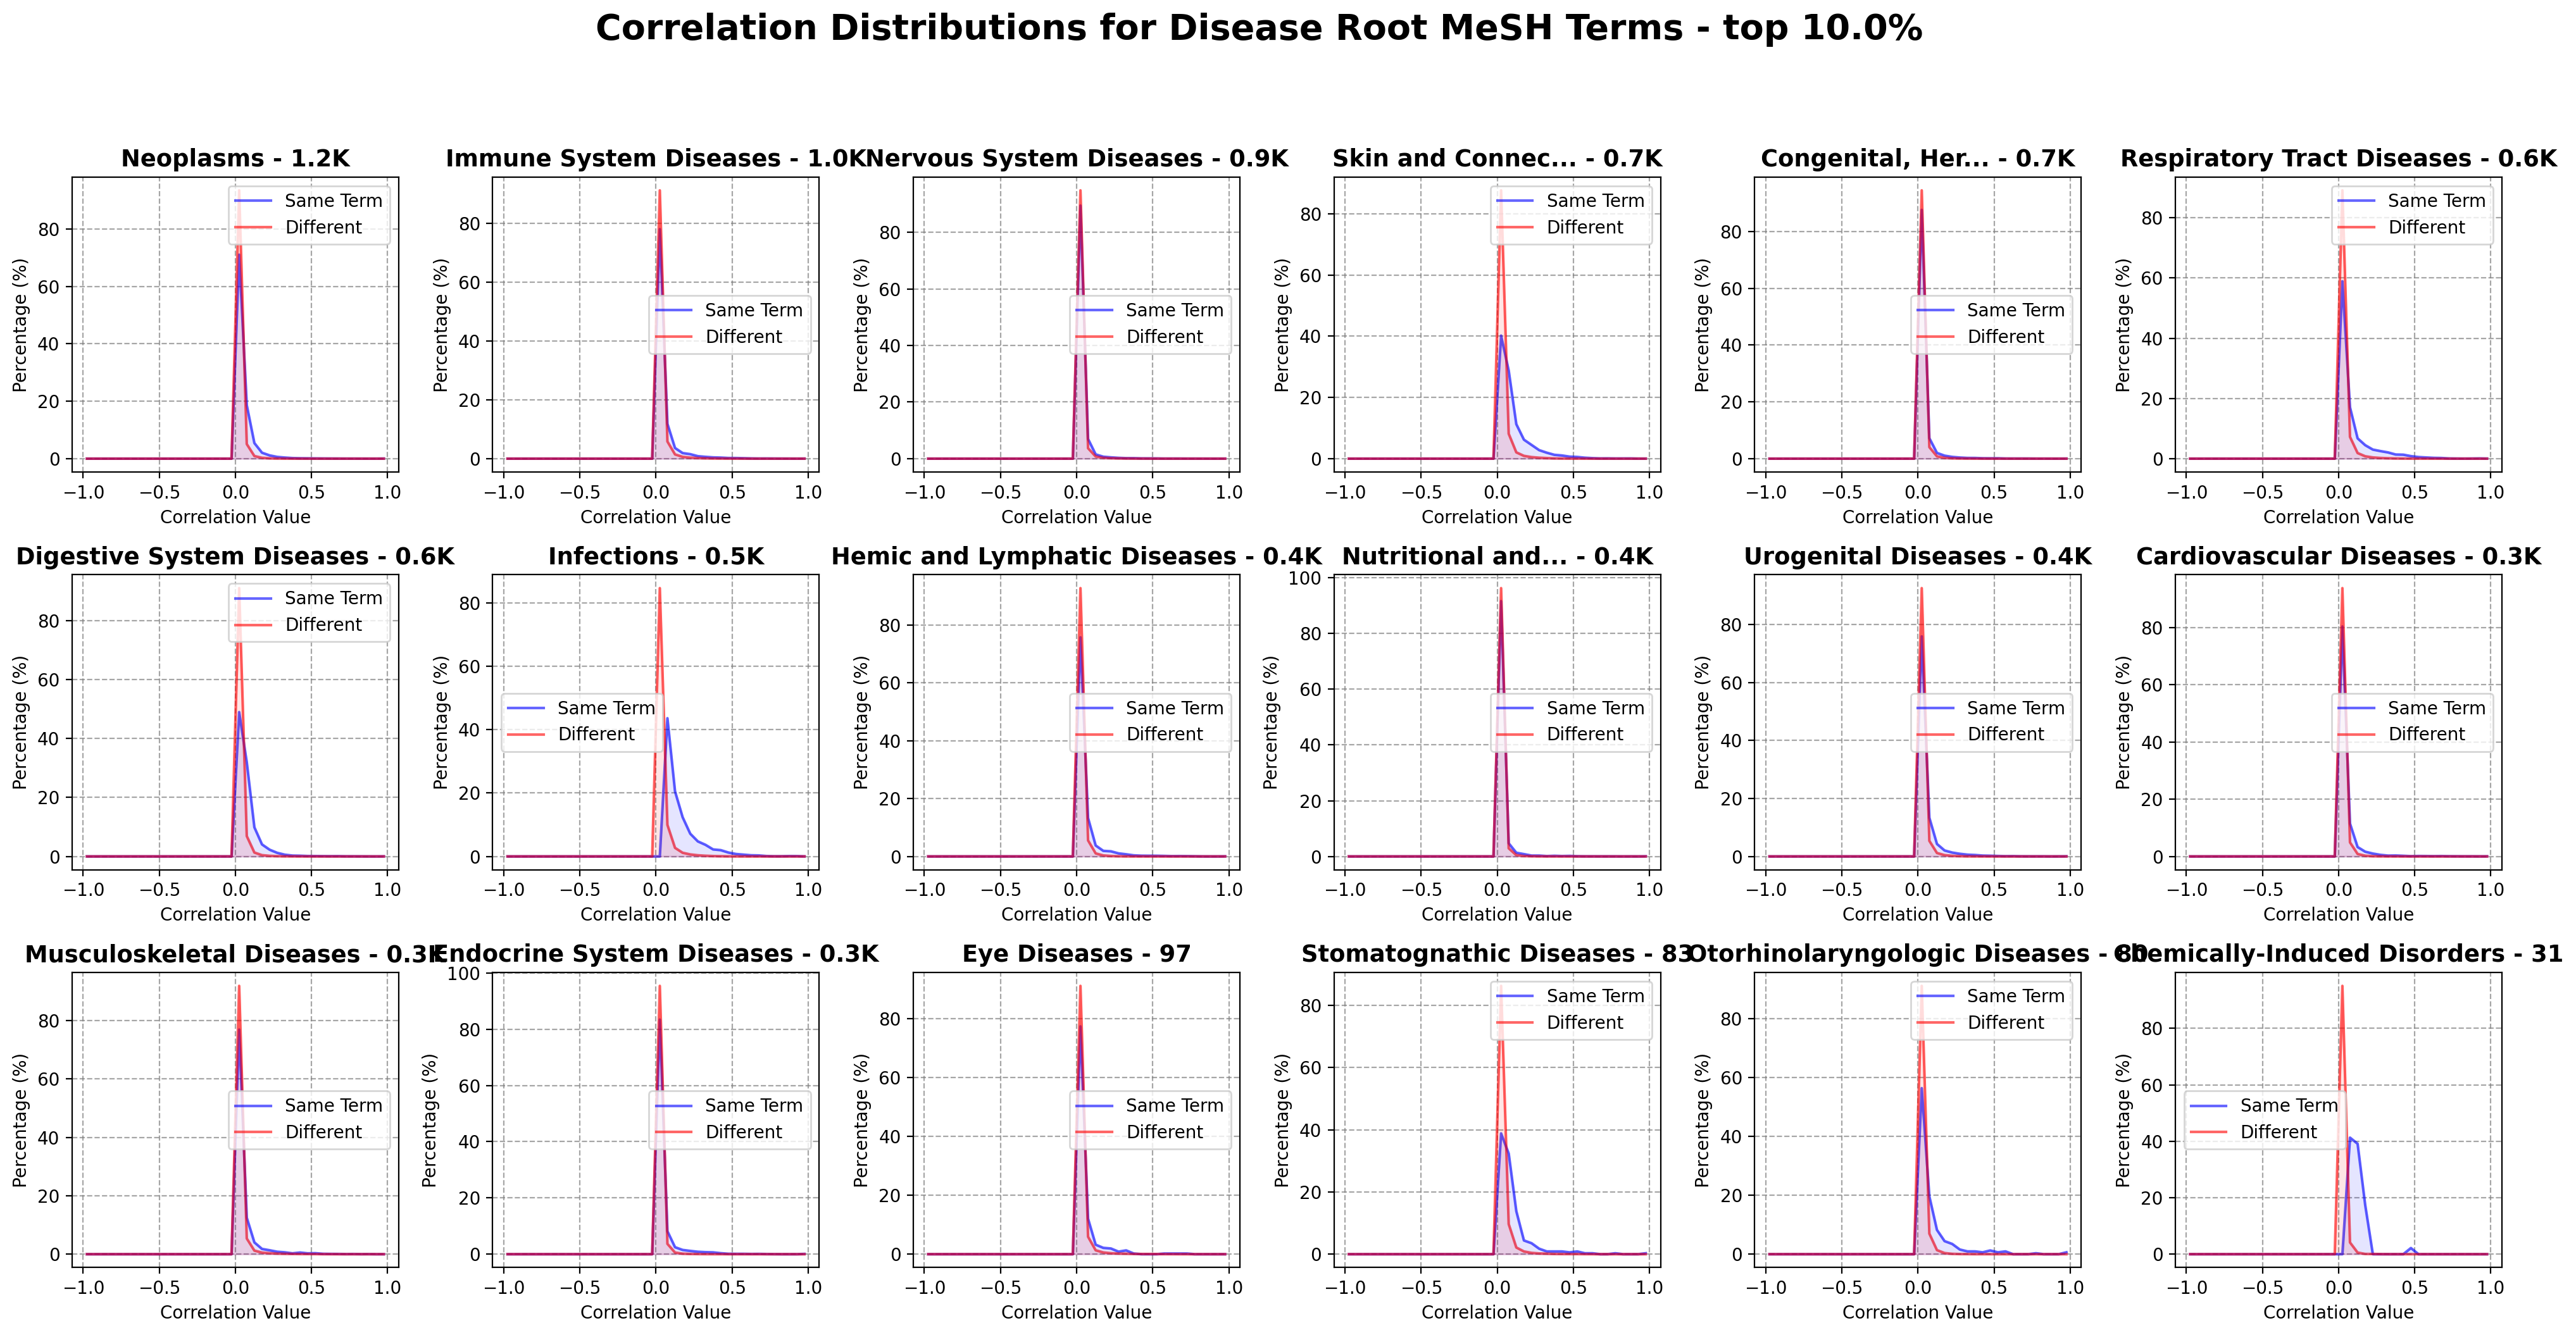

In [444]:
"""Plot Signature Correlation

The aim here will be to plot correlations between same and different diseases
classified through their MeSH terms

Structure:
    1. Imports, Variables, Functions
    2. Plot ROOT terms 
    3. Plot SPECIFIC terms
"""

# 1. Imports, Variables, Functions
# imports

# variables
path_correlation = os.path.join("..", "data", "DiSignAtlas", "correlation.h5")

# functions


def get_correlation_values(
    correlation_matrix, all_dsaid_microarray, dsaids_1, same=True
):
    """Get Correlation Values From Matrix
    It load pre-computed correlation values and retrieve them.
    We can either retrieve the correlation values between one set of dataset
    ids (dsaids_1) or between two sets of dataset ids (dsaids_1 and dsaids_2)

    Arguments:
        correlation_matrix (numpy): correlation matrix of all signatures
        all_dsaid_microarray (list): all dataset ids
        dsaids_1 (list): dataset ids of interest
        same (bool): dataset ids of interest against
        themselves (True) or against rest (False)

    Returns:
        correlation_values (list): correlation values
    """

    # Map dataset ids to indexes
    idxs_1 = np.where(np.isin(all_dsaid_microarray, dsaids_1))[0]

    # dsaids_1 against themselves
    # we want to retrieve the upper triangular part of the correlation matrix !
    if same:
        correlation_values_matrix = correlation_matrix[np.ix_(idxs_1, idxs_1)]
        lower_diagonal_indexes = np.tril_indices(len(idxs_1), k=-1)
        correlation_values = correlation_values_matrix[lower_diagonal_indexes]

        logging.info(
            f"{len(correlation_values)} correlation values for {len(idxs_1)} datasets retrieved from correlation matrix"
        )
    # dsaids_1 against rest

    else:
        # idxs_2 = np.where(np.isin(all_dsaid_microarray, dsaids_2))[0]
        idxs_2 = np.where(~np.isin(all_dsaid_microarray, dsaids_1))[0]
        correlation_values_matrix = correlation_matrix[np.ix_(idxs_1, idxs_2)]
        correlation_values = correlation_values_matrix.flatten()

        logging.info(
            f"{len(correlation_values)} correlation values for {len(idxs_1)} vs {len(idxs_2)} datasets retrieved from correlation matrix"
        )

    return correlation_values


def get_top_PERCENT_values(PERCENT, values):
    """Get Top Percent Values
    Arguments
        - PERCENT (int): top percent of values
        - values (list): values
    Returns
        - top_percent_values (list): top percent values
    """
    # sort values
    sorted_values = sorted(list(values), reverse=True)

    # index of top percent values
    top_index = int(PERCENT * len(sorted_values))

    # get top percent values
    top_percent_values = sorted_values[:top_index]
    return np.array(top_percent_values)


def get_dsaids_with_term(term_interest, dsaids, disease_id_2_mesh):
    """Get DSAIDs with Term
    Arguments:
        term_interest (str): term of interest
        dsaid (list): list of dsaids
        disease_id_2_mesh (dict): dictionary of dsaids and their symbols
    Returns:
        found_dsaids (list): list of dsaids which have the term of interest
    """

    found_dsaids = list()

    # iterate through datasets & their symbols
    for dsaid in dsaids:
        symbols = disease_id_2_mesh[dsaid]["symbols"]
        symbols_disease = [s for s in symbols if s.startswith("C")]

        # iterate through different symbols
        for symbol in symbols_disease:
            symbol_levels = symbol.split(".")
            flag = False

            # iterate through different symbol levels
            for i in range(len(symbol_levels)):
                symbol_level = ".".join(symbol_levels[: i + 1])
                term = mesh_symbol_2_term[symbol_level]

                # if term belongs to branch terms of interest
                if term == term_interest:
                    found_dsaids.append(dsaid)
                    flag = True
                    break  # stop iterating through levels of a term

            # stop iterating through symbols of a dataset
            # move on to the next dataset
            if flag:
                break

    # check if dsaids are unique
    assert len(found_dsaids) == len(
        set(found_dsaids)
    ), "Err Something went wrong :( dsaids are not unique"

    return found_dsaids


# 2. Load Correlation Data
# open h5 file
with h5py.File(path_correlation, "r") as f:
    # Read the data
    all_dsaid_microarray = f["id"][:].astype("<U")
    correlation_matrix = f["V"][:]
    # Read the attributes
    logging.info(f["id"].attrs["description"])
    logging.info(f["V"].attrs["description"])

#### d.5.1 Root Terms

In [ ]:
# 3. Plot ROOT terms
""" Plot ROOT terms
Steps: 
    a. Retrieve top N terms which are root terms
    b. Get dataset ids for these terms which are ALSO human
    c. Plot Correlation values
"""


# a. Retrieve top N terms which are root terms
N = 18
PERCENT = 0.1
# create list of root mesh terms
level = 0
level_split = level * 4 + 3
root_symbols_all = list()
filter_criteria = lambda t: t.startswith("C") and not t.startswith(
    "C23"
)  # we filter out C23 - symptoms

# iterate through datasets and their MeSH terms
for k in dsaids_human:
    if disease_id_2_mesh[k]["symbols"] is not None:
        symbols = disease_id_2_mesh[k]["symbols"]

        symbols_specific_level = list(
            set([s[:level_split] for s in symbols if filter_criteria(s)])
        )
        root_symbols_all.append(symbols_specific_level)

# root symbols all will be a list of lists - we do this because
# sometimes different symbols have the same term - we will translate the
# list of set terms to avoid over-estimation
# this is not likely to happen because this problem occurs when dealing
# with quite different symbols - but it is good practice anyways
root_terms = list()

# iterate through sublist of root symbols
for root_symbols_sublist in root_symbols_all:
    terms = set()
    # iterate through root symbols
    for root_symbol in root_symbols_sublist:
        terms.add(mesh_symbol_2_term[root_symbol])
    # append after looping though all root symbols
    # the set of terms to the root terms list
    root_terms.extend(list(terms))

sorted_tupples = sorted(Counter(root_terms).items(), key=lambda x: x[1], reverse=True)
top_terms = [t[0] for t in sorted_tupples]
logging.info(sorted_tupples[:N])

# b. Get dataset ids for these terms which are ALSO human
# Set up a 3x6 grid of plots
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10), dpi=200)
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Define bin width and range
bin_width = 0.05  # Adjust as needed
bin_range = (-1, 1)  # Adjust as needed
bins = np.arange(bin_range[0], bin_range[1] + bin_width, bin_width)

for ax, term in zip(axes, top_terms[:N]):
    dsaids_interest = list()

    # retieve dataset ids of interest
    # iterate through datasets
    for dsaid in dsaids_human:
        flag = False
        # iterate through mesh_symbols in datases
        for mesh_symbol in disease_id_2_mesh[dsaid]["symbols"]:
            # iterate through mesh_terms of interest

            for mesh_symbol_interest in mesh_term_2_symbols[term]:
                # if it finds it break both mesh terms of interest group AND
                # mesh symbols of datasets
                # move on to NEXT dataset ! ! !
                if mesh_symbol.startswith(mesh_symbol_interest):
                    dsaids_interest.append(dsaid)
                    flag = True
                    break
            if flag:
                break

    logging.info(f"Nº of MeSH symbols of interest for {term}: {len(dsaids_interest)}")

    # compute same correlation values
    same_correlation_values = get_correlation_values(
        correlation_matrix=correlation_matrix,
        all_dsaid_microarray=all_dsaid_microarray,
        dsaids_1=dsaids_interest,
        same=True,
    )

    top_same_correlation_values = get_top_PERCENT_values(
        PERCENT=PERCENT, values=same_correlation_values
    )

    # compute different correlation values
    diff_correlation_values = get_correlation_values(
        correlation_matrix=correlation_matrix,
        all_dsaid_microarray=all_dsaid_microarray,
        dsaids_1=dsaids_interest,
        same=False,
    )

    top_diff_correlation_values = get_top_PERCENT_values(
        PERCENT=PERCENT, values=diff_correlation_values
    )

    # c. Plot Correlation values
    # Calculate histograms and convert to percentages
    counts_same, _ = np.histogram(top_same_correlation_values, bins=bins)
    counts_diff, _ = np.histogram(top_diff_correlation_values, bins=bins)
    percent_same = counts_same * 100 / counts_same.sum()
    percent_diff = counts_diff * 100 / counts_diff.sum()

    # Calculate bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Plot lines and fill area under the lines
    ax.plot(bin_centers, percent_same, color="blue", alpha=0.6, zorder=3)
    ax.plot(bin_centers, percent_diff, color="red", alpha=0.6, zorder=3)
    ax.fill_between(bin_centers, percent_same, color="blue", alpha=0.1, zorder=3)
    ax.fill_between(bin_centers, percent_diff, color="red", alpha=0.1, zorder=3)

    # Set title and labels for each subplot
    term_translation = (
        "Skin and Connective Tissue D."
        if term == "Skin and Connective Tissue Diseases"
        else "Nutritional and Metabolic D."
        if term == "Nutritional and Metabolic Diseases"
        else "Congenital D. & Abnormalities"
        if term == "Congenital, Hereditary, and Neonatal Diseases and Abnormalities"
        else "Pathological Conditions"
        if term == "Pathological Conditions, Signs and Symptoms"
        else term
    )
    # Set title and labels for each subplot
    term_sliced = term[:15] + "..." if len(term) > 30 else term

    num_dsaids = len(dsaids_interest)
    if num_dsaids >= 1000:
        formatted_num = "{:.1f}K".format(num_dsaids / 1000)
    elif num_dsaids >= 100:
        formatted_num = "{:.1f}K".format(num_dsaids / 1000)
    else:
        formatted_num = str(num_dsaids)

    ax.set_title(
        "%s - %s" % (term_sliced, formatted_num),
        fontsize=13.25,
        fontweight="bold",
    )

    # ax.set_title(term_translation, fontsize=13.25, fontweight="bold")
    ax.set_xlabel("Correlation Value", fontsize=10)
    ax.set_ylabel("Percentage (%)", fontsize=10)
    ax.legend(["Same Term", "Different"], fontsize=10)
    ax.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Adjust layout
fig.suptitle(
    f"Correlation Distributions for Disease Root MeSH Terms - top {PERCENT*100}%",
    fontsize=20,
    fontweight="bold",
    y=1.05,
)
plt.tight_layout()

#### d.5.2 Leaf MeSH Terms

In [440]:
# 4. Plot SPECIFIC terms
""" Plot LEAF terms
Steps: 
    a. Retrieve top N terms which are root terms
    b. Get dataset ids for these terms which are ALSO human
    c. Plot Correlation values
"""


# a. Retrieve top N terms which are root terms
N = 18
PERCENT = 0.1

# create list of root mesh terms
level = 3
level_split = level * 4 + 3
root_symbols_all = list()
filter_criteria = lambda t: t.startswith("C04") and not t.startswith(
    "C23"
)  # we filter out C23 - symptoms

# iterate through datasets and their MeSH terms
for k in dsaids_human:
    if disease_id_2_mesh[k]["symbols"] is not None:
        symbols = disease_id_2_mesh[k]["symbols"]

        symbols_specific_level = list(
            set([s[:level_split] for s in symbols if filter_criteria(s)])
        )
        root_symbols_all.append(symbols_specific_level)

# root symbols all will be a list of lists - we do this because
# sometimes different symbols have the same term - we will translate the
# list of set terms to avoid over-estimation
# this is not likely to happen because this problem occurs when dealing
# with quite different symbols - but it is good practice anyways
root_terms = list()

# iterate through sublist of root symbols
for root_symbols_sublist in root_symbols_all:
    terms = set()
    # iterate through root symbols
    for root_symbol in root_symbols_sublist:
        terms.add(mesh_symbol_2_term[root_symbol])
    # append after looping though all root symbols
    # the set of terms to the root terms list
    root_terms.extend(list(terms))

sorted_tupples = sorted(Counter(root_terms).items(), key=lambda x: x[1], reverse=True)
top_terms = [t[0] for t in sorted_tupples]
logging.info(sorted_tupples[:N])

# b. Get dataset ids for these terms which are ALSO human
# Set up a 3x6 grid of plots
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10), dpi=200)
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Define bin width and range
bin_width = 0.05  # Adjust as needed
bin_range = (-1, 1)  # Adjust as needed
bins = np.arange(bin_range[0], bin_range[1] + bin_width, bin_width)

for ax, term in zip(axes, top_terms[:N]):
    dsaids_interest = list()

    # retieve dataset ids of interest
    # iterate through datasets
    for dsaid in dsaids_human:
        flag = False
        # iterate through mesh_symbols in datases
        for mesh_symbol in disease_id_2_mesh[dsaid]["symbols"]:
            # iterate through mesh_terms of interest

            for mesh_symbol_interest in mesh_term_2_symbols[term]:
                # if it finds it break both mesh terms of interest group AND
                # mesh symbols of datasets
                # move on to NEXT dataset ! ! !
                if mesh_symbol.startswith(mesh_symbol_interest):
                    dsaids_interest.append(dsaid)
                    flag = True
                    break
            if flag:
                break

    logging.info(f"Nº of MeSH symbols of interest for {term}: {len(dsaids_interest)}")

    # compute same correlation values
    same_correlation_values = get_correlation_values(
        correlation_matrix=correlation_matrix,
        all_dsaid_microarray=all_dsaid_microarray,
        dsaids_1=dsaids_interest,
        same=True,
    )

    top_same_correlation_values = get_top_PERCENT_values(
        PERCENT=PERCENT, values=same_correlation_values
    )

    # compute different correlation values
    diff_correlation_values = get_correlation_values(
        correlation_matrix=correlation_matrix,
        all_dsaid_microarray=all_dsaid_microarray,
        dsaids_1=dsaids_interest,
        same=False,
    )

    top_diff_correlation_values = get_top_PERCENT_values(
        PERCENT=PERCENT, values=diff_correlation_values
    )

    # c. Plot Correlation values
    # Calculate histograms and convert to percentages
    counts_same, _ = np.histogram(top_same_correlation_values, bins=bins)
    counts_diff, _ = np.histogram(top_diff_correlation_values, bins=bins)
    percent_same = counts_same * 100 / counts_same.sum()
    percent_diff = counts_diff * 100 / counts_diff.sum()

    # Calculate bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Plot lines and fill area under the lines
    ax.plot(bin_centers, percent_same, color="blue", alpha=0.6, zorder=3)
    ax.plot(bin_centers, percent_diff, color="red", alpha=0.6, zorder=3)
    ax.fill_between(bin_centers, percent_same, color="blue", alpha=0.1, zorder=3)
    ax.fill_between(bin_centers, percent_diff, color="red", alpha=0.1, zorder=3)

    # Set title and labels for each subplot
    term_translation = (
        "Skin and Connective Tissue D."
        if term == "Skin and Connective Tissue Diseases"
        else "Nutritional and Metabolic D."
        if term == "Nutritional and Metabolic Diseases"
        else "Congenital D. & Abnormalities"
        if term == "Congenital, Hereditary, and Neonatal Diseases and Abnormalities"
        else "Pathological Conditions"
        if term == "Pathological Conditions, Signs and Symptoms"
        else term
    )

    ax.set_title(term_translation, fontsize=13.25, fontweight="bold")
    ax.set_xlabel("Correlation Value", fontsize=10)
    ax.set_ylabel("Percentage (%)", fontsize=10)
    ax.legend(["Same Term", "Different"], fontsize=10)
    ax.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Adjust layout
fig.suptitle(
    "Correlation Distributions for Disease Root MeSH Terms",
    fontsize=20,
    fontweight="bold",
    y=1.05,
)
plt.tight_layout()

2024-01-18 19:03:44,584 - INFO - [('Carcinoma', 208), ('Neuroectodermal Tumors', 173), ('Leukemia, Myeloid', 128), ('Gastrointestinal Neoplasms', 119), ('Neoplasms, Neuroepithelial', 111), ('Breast Neoplasms', 83), ('Urologic Neoplasms', 63), ('Leukemia, Lymphoid', 59), ('Respiratory Tract Neoplasms', 56), ('Melanoma', 52), ('Lymphoma, Non-Hodgkin', 43), ('Multiple Myeloma', 35), ('Central Nervous System Neoplasms', 34), ('Ovarian Neoplasms', 32), ('Polycystic Ovary Syndrome', 30), ('Thyroid Neoplasms', 30), ('Sarcoma', 28), ('Neoplasms, Squamous Cell', 26)]
2024-01-18 19:03:44,659 - INFO - Nº of MeSH symbols of interest for Carcinoma: 208
2024-01-18 19:03:44,661 - INFO - 21528 correlation values for 208 datasets retrieved from correlation matrix
2024-01-18 19:03:44,672 - INFO - 2020512 correlation values for 208 vs 9714 datasets retrieved from correlation matrix
2024-01-18 19:03:45,615 - INFO - Nº of MeSH symbols of interest for Neuroectodermal Tumors: 173
2024-01-18 19:03:45,618 - IN

#### d.5.3 Specific Leaf Terms MeSH Terms

In [ ]:
# variables
root = "C04"  # get all terms within a branch for a specific root
N = 18
PERCENT = 0.1

# MeSH Hierarchical level we are interested in
level = 3
level_split = level * 4 + 3

# iterate through all symbols
branch_terms = set()
list_branch_terms = list()
n_terms_below_level = 0
n_terms_absolute_leaf = 0
for s in mesh_symbol_2_term.keys():
    if s.startswith(root) & (len(s) >= level_split):
        branch_terms.add(mesh_symbol_2_term[s])
        list_branch_terms.append(mesh_symbol_2_term[s])
        n_terms_below_level += 1
    # if the symbol is above the hierarchical level we are interested in
    # we can still add it if it is an "absolute" leaf meaning that it
    # has no children
    elif s.startswith(root) & (len(s) < level_split):
        # check if it has children but exclude root term
        children = [k for k in mesh_symbol_2_term.keys() if k.startswith(s) & (k != s)]
        if len(children) == 0 and len(s) >= 4:
            branch_terms.add(mesh_symbol_2_term[s])
            list_branch_terms.append(mesh_symbol_2_term[s])
            n_terms_absolute_leaf += 1
        else:
            continue  # if it has children we do not add it

assert len(branch_terms) == len(set(list_branch_terms)), "Err Something went wrong :("

logging.info(
    f"Nº of found terms: {len(list_branch_terms)} of which unique {len(branch_terms)}"
)
logging.info(
    f"Nº of terms below level: {n_terms_below_level} Nº of absolute leaf terms: {n_terms_absolute_leaf}"
)


# search for branch terms
# iterate through datasets & their symbols
found_terms = list()
for dsaid in human_dsaids:
    symbols = disease_id_2_mesh[dsaid]["symbols"]
    symbols_disease = [s for s in symbols if s.startswith("C")]
    terms = set()

    # iterate through disease symbols
    for symbol in symbols_disease:
        symbol_levels = symbol.split(".")

        # iterate through different symbol levels
        for i in range(len(symbol_levels)):
            symbol_level = ".".join(symbol_levels[: i + 1])
            term = mesh_symbol_2_term[symbol_level]

            # if term belongs to branch terms of interest
            if term in branch_terms:
                terms.add(term)

    # append to found terms
    found_terms.extend(list(terms))


sorted_tupples = sorted(Counter(found_terms).items(), key=lambda x: x[1], reverse=True)
top_terms = [t[0] for t in sorted_tupples]
logging.info(sorted_tupples[:N])

# b. Get dataset ids for these terms which are ALSO human
# Set up a 3x6 grid of plots
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10), dpi=200)
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Define bin width and range
bin_width = 0.05  # Adjust as needed
bin_range = (-1, 1)  # Adjust as needed
bins = np.arange(bin_range[0], bin_range[1] + bin_width, bin_width)

for ax, term in zip(axes, top_terms[:N]):
    dsaids_interest = list()

    # retrieve dataset ids of interest

    dsaids_interest = get_dsaids_with_term(
        term_interest=term, dsaids=human_dsaids, disease_id_2_mesh=disease_id_2_mesh
    )

    logging.info(f"Nº of MeSH symbols of interest for {term}: {len(dsaids_interest)}")

    # compute same correlation values
    same_correlation_values = get_correlation_values(
        correlation_matrix=correlation_matrix,
        all_dsaid_microarray=all_dsaid_microarray,
        dsaids_1=dsaids_interest,
        same=True,
    )

    top_same_correlation_values = get_top_PERCENT_values(
        PERCENT=PERCENT, values=same_correlation_values
    )

    # compute different correlation values
    diff_correlation_values = get_correlation_values(
        correlation_matrix=correlation_matrix,
        all_dsaid_microarray=all_dsaid_microarray,
        dsaids_1=dsaids_interest,
        same=False,
    )

    top_diff_correlation_values = get_top_PERCENT_values(
        PERCENT=PERCENT, values=diff_correlation_values
    )

    # c. Plot Correlation values
    # Calculate histograms and convert to percentages
    counts_same, _ = np.histogram(top_same_correlation_values, bins=bins)
    counts_diff, _ = np.histogram(top_diff_correlation_values, bins=bins)
    percent_same = counts_same * 100 / counts_same.sum()
    percent_diff = counts_diff * 100 / counts_diff.sum()

    # Calculate bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Plot lines and fill area under the lines
    ax.plot(bin_centers, percent_same, color="blue", alpha=0.6, zorder=3)
    ax.plot(bin_centers, percent_diff, color="red", alpha=0.6, zorder=3)
    ax.fill_between(bin_centers, percent_same, color="blue", alpha=0.1, zorder=3)
    ax.fill_between(bin_centers, percent_diff, color="red", alpha=0.1, zorder=3)

    # Set title and labels for each subplot
    term_sliced = term[:25] + "..." if len(term) > 30 else term

    num_dsaids = len(dsaids_interest)
    if num_dsaids >= 1000:
        formatted_num = "{:.1f}K".format(num_dsaids / 1000)
    elif num_dsaids >= 100:
        formatted_num = "{:.1f}K".format(num_dsaids / 1000)
    else:
        formatted_num = str(num_dsaids)

    ax.set_title(
        "%s - %s" % (term_sliced, num_dsaids),
        fontsize=13.25,
        fontweight="bold",
    )
    ax.set_xlabel("Correlatitermon Value", fontsize=10)
    ax.set_ylabel("Percentage (%)", fontsize=10)
    ax.legend(["Same Term", "Different"], fontsize=10)
    ax.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Adjust layout
fig.suptitle(
    f"Correlation Distributions for Disease Root MeSH Terms - TOP {PERCENT*100}%",
    fontsize=20,
    fontweight="bold",
    y=1.05,
)
plt.tight_layout()

In [ ]:
# 4. Plot SPECIFIC terms
""" Plot LEAF terms
Steps: 
    a. Retrieve top N terms which are root terms
    b. Get dataset ids for these terms which are ALSO human
    c. Plot Correlation values
"""


# a. Retrieve top N terms which are root terms
N = 18
PERCENT = 0.1

# create list of root mesh terms
level = 3
level_split = level * 4 + 3
root_symbols_all = list()
filter_criteria = lambda t: t.startswith("C04") and not t.startswith(
    "C23"
)  # we filter out C23 - symptoms

# iterate through datasets and their MeSH terms
for k in dsaids_human:
    if disease_id_2_mesh[k]["symbols"] is not None:
        symbols = disease_id_2_mesh[k]["symbols"]

        symbols_specific_level = list(
            set([s[:level_split] for s in symbols if filter_criteria(s)])
        )
        root_symbols_all.append(symbols_specific_level)

# root symbols all will be a list of lists - we do this because
# sometimes different symbols have the same term - we will translate the
# list of set terms to avoid over-estimation
# this is not likely to happen because this problem occurs when dealing
# with quite different symbols - but it is good practice anyways
root_terms = list()

# iterate through sublist of root symbols
for root_symbols_sublist in root_symbols_all:
    terms = set()
    # iterate through root symbols
    for root_symbol in root_symbols_sublist:
        terms.add(mesh_symbol_2_term[root_symbol])
    # append after looping though all root symbols
    # the set of terms to the root terms list
    root_terms.extend(list(terms))

sorted_tupples = sorted(Counter(root_terms).items(), key=lambda x: x[1], reverse=True)
top_terms = [t[0] for t in sorted_tupples]
logging.info(sorted_tupples[:N])

# b. Get dataset ids for these terms which are ALSO human
# Set up a 3x6 grid of plots
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10), dpi=200)
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Define bin width and range
bin_width = 0.05  # Adjust as needed
bin_range = (-1, 1)  # Adjust as needed
bins = np.arange(bin_range[0], bin_range[1] + bin_width, bin_width)

for ax, term in zip(axes, top_terms[:N]):
    dsaids_interest = list()

    # retieve dataset ids of interest
    # iterate through datasets
    for dsaid in dsaids_human:
        flag = False
        # iterate through mesh_symbols in datases
        for mesh_symbol in disease_id_2_mesh[dsaid]["symbols"]:
            # iterate through mesh_terms of interest

            for mesh_symbol_interest in mesh_term_2_symbols[term]:
                # if it finds it break both mesh terms of interest group AND
                # mesh symbols of datasets
                # move on to NEXT dataset ! ! !
                if mesh_symbol.startswith(mesh_symbol_interest):
                    dsaids_interest.append(dsaid)
                    flag = True
                    break
            if flag:
                break

    logging.info(f"Nº of MeSH symbols of interest for {term}: {len(dsaids_interest)}")

    # compute same correlation values
    same_correlation_values = get_correlation_values(
        correlation_matrix=correlation_matrix,
        all_dsaid_microarray=all_dsaid_microarray,
        dsaids_1=dsaids_interest,
        same=True,
    )

    top_same_correlation_values = get_top_PERCENT_values(
        PERCENT=PERCENT, values=same_correlation_values
    )

    # compute different correlation values
    diff_correlation_values = get_correlation_values(
        correlation_matrix=correlation_matrix,
        all_dsaid_microarray=all_dsaid_microarray,
        dsaids_1=dsaids_interest,
        same=False,
    )

    top_diff_correlation_values = get_top_PERCENT_values(
        PERCENT=PERCENT, values=diff_correlation_values
    )

    # c. Plot Correlation values
    # Calculate histograms and convert to percentages
    counts_same, _ = np.histogram(top_same_correlation_values, bins=bins)
    counts_diff, _ = np.histogram(top_diff_correlation_values, bins=bins)
    percent_same = counts_same * 100 / counts_same.sum()
    percent_diff = counts_diff * 100 / counts_diff.sum()

    # Calculate bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Plot lines and fill area under the lines
    ax.plot(bin_centers, percent_same, color="blue", alpha=0.6, zorder=3)
    ax.plot(bin_centers, percent_diff, color="red", alpha=0.6, zorder=3)
    ax.fill_between(bin_centers, percent_same, color="blue", alpha=0.1, zorder=3)
    ax.fill_between(bin_centers, percent_diff, color="red", alpha=0.1, zorder=3)

    # Set title and labels for each subplot
    term_translation = (
        "Skin and Connective Tissue D."
        if term == "Skin and Connective Tissue Diseases"
        else "Nutritional and Metabolic D."
        if term == "Nutritional and Metabolic Diseases"
        else "Congenital D. & Abnormalities"
        if term == "Congenital, Hereditary, and Neonatal Diseases and Abnormalities"
        else "Pathological Conditions"
        if term == "Pathological Conditions, Signs and Symptoms"
        else term
    )

    ax.set_title(term_translation, fontsize=13.25, fontweight="bold")
    ax.set_xlabel("Correlation Value", fontsize=10)
    ax.set_ylabel("Percentage (%)", fontsize=10)
    ax.legend(["Same Term", "Different"], fontsize=10)
    ax.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Adjust layout
fig.suptitle(
    "Correlation Distributions for Disease Root MeSH Terms",
    fontsize=20,
    fontweight="bold",
    y=1.05,
)
plt.tight_layout()

2024-01-18 19:03:44,584 - INFO - [('Carcinoma', 208), ('Neuroectodermal Tumors', 173), ('Leukemia, Myeloid', 128), ('Gastrointestinal Neoplasms', 119), ('Neoplasms, Neuroepithelial', 111), ('Breast Neoplasms', 83), ('Urologic Neoplasms', 63), ('Leukemia, Lymphoid', 59), ('Respiratory Tract Neoplasms', 56), ('Melanoma', 52), ('Lymphoma, Non-Hodgkin', 43), ('Multiple Myeloma', 35), ('Central Nervous System Neoplasms', 34), ('Ovarian Neoplasms', 32), ('Polycystic Ovary Syndrome', 30), ('Thyroid Neoplasms', 30), ('Sarcoma', 28), ('Neoplasms, Squamous Cell', 26)]
2024-01-18 19:03:44,659 - INFO - Nº of MeSH symbols of interest for Carcinoma: 208
2024-01-18 19:03:44,661 - INFO - 21528 correlation values for 208 datasets retrieved from correlation matrix
2024-01-18 19:03:44,672 - INFO - 2020512 correlation values for 208 vs 9714 datasets retrieved from correlation matrix
2024-01-18 19:03:45,615 - INFO - Nº of MeSH symbols of interest for Neuroectodermal Tumors: 173
2024-01-18 19:03:45,618 - IN

## e. Output to CSV files


In [675]:
"""Output to CSV files

Structure:
    1. Imports, Variables, Functions
    2. Root terms
    3. All Leaf terms
"""

# 1. Imports, Variables, Functions
# imports
import pandas as pd

# variables
csv_output_path = os.path.join("..", "results", "files", "DiSignAtlas")
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)
filter_criteria = lambda t: t.startswith("C") and not t.startswith(
    "C23"
)  # we filter out C23 - symptoms

# functions


# 2. Load data
df_data_info = pd.read_csv(data_info_path)
disease_id_2_accession = dict(zip(df_data_info["dsaid"], df_data_info["accession"]))
disease_id_2_organism = dict(zip(df_data_info["dsaid"], df_data_info["organism"]))
disease_id_2_tissue = dict(zip(df_data_info["dsaid"], df_data_info["tissue"]))

# check df loaded correctly
assert (
    len(df_data_info.value_counts(["organism"])) == 2
), "Err there should be only two organisms"

In [707]:
disease_id_2_tissue["DSA00007"]

nan

In [708]:
if np.isnan(disease_id_2_tissue["DSA00007"]):
    print("t")

t


#### e.1 Root terms

In [729]:
# 3. Root terms

# list of dsaids which are from microarray data, for which we can
# build signatures and are microarray data

root_symbols = [
    s for s in mesh_symbol_2_term.keys() if filter_criteria(s) and len(s) < 5
]
root_terms = [mesh_symbol_2_term[s] for s in root_symbols]

data = list()
for term in tqdm(root_terms):
    # get dsaids with term
    found_dsaids = get_dsaids_with_term(
        term_interest=term,
        dsaids=list(disease_id_2_mesh.keys()),
        disease_id_2_mesh=disease_id_2_mesh,
    )

    assert len(found_dsaids) == len(
        set(found_dsaids)
    ), "Err Something went wrong :( dsaids are not unique"

    # get number of signatures
    n_signatures = len(found_dsaids)

    # get number of datasets
    datasets = [disease_id_2_accession.get(dsaid) for dsaid in found_dsaids]
    n_dataset = len(set(datasets))

    # get number of tissues
    tissues = [
        disease_id_2_tissue.get(dsaid)
        for dsaid in found_dsaids
        if type(disease_id_2_tissue.get(dsaid)) is str
    ]
    n_tissue_info = len(tissues)
    n_tissue_types = len(set(tissues))

    # get number of human sigantures
    organisms = [disease_id_2_organism.get(dsaid) for dsaid in found_dsaids]
    n_human = Counter(organisms)["Homo sapiens"]
    logging.info(Counter(organisms))

    # get number if human datasets
    human_found_dsaids = [
        dsaid
        for dsaid in found_dsaids
        if disease_id_2_organism.get(dsaid) == "Homo sapiens"
    ]
    human_dataset_ids = [
        disease_id_2_accession.get(dsaid) for dsaid in human_found_dsaids
    ]
    n_human_datasets = len(set(human_dataset_ids))

    # get number of human tissues
    human_tissues = [
        disease_id_2_tissue.get(dsaid)
        for dsaid in human_found_dsaids
        if type(disease_id_2_tissue.get(dsaid)) is str
    ]
    n_human_tissue_info = len(human_tissues)
    n_human_tissue_types = len(set(human_tissues))

    # Create a new row as a dictionary
    new_row = {
        "ROOT_TERM": term,
        "N_SIGNATURES": n_signatures,
        "N_TISSUE_INFO": n_tissue_info,
        "N_TISSUE_TYPES": n_tissue_types,
        "N_DATASETS": n_dataset,
        "N_HUMAN_SIGNATURES": n_human,
        "N_HUMAN_TISSUE_INFO": n_human_tissue_info,
        "N_HUMAN_TISSUE_TYPES": n_human_tissue_types,
        "N_HUMAN_DATASETS": n_human_datasets,
    }  # Replace with actual values

    data.append(new_row)

df_root_info = pd.DataFrame(data)

# sort Data Frame by "N_SIGNATURES"
df_root_info.sort_values(by="N_SIGNATURES", ascending=False, inplace=True)

# check what it looks like :)
df_root_info.head()

  0%|          | 0/22 [00:00<?, ?it/s]2024-01-21 21:26:00,094 - INFO - Counter({'Homo sapiens': 394, 'Mus musculus': 114})
2024-01-21 21:26:00,138 - INFO - Counter({'Mus musculus': 4, 'Homo sapiens': 3})
2024-01-21 21:26:00,168 - INFO - Counter({'Homo sapiens': 357, 'Mus musculus': 204})
 14%|█▎        | 3/22 [00:00<00:00, 24.50it/s]2024-01-21 21:26:00,200 - INFO - Counter({'Homo sapiens': 642, 'Mus musculus': 320})
2024-01-21 21:26:00,234 - INFO - Counter({'Homo sapiens': 302, 'Mus musculus': 81})
2024-01-21 21:26:00,266 - INFO - Counter({'Homo sapiens': 102, 'Mus musculus': 44})
2024-01-21 21:26:00,299 - INFO - Counter({'Homo sapiens': 481, 'Mus musculus': 94})
 32%|███▏      | 7/22 [00:00<00:00, 28.06it/s]2024-01-21 21:26:00,331 - INFO - Counter({'Homo sapiens': 1050, 'Mus musculus': 153})
2024-01-21 21:26:00,360 - INFO - Counter({'Homo sapiens': 553, 'Mus musculus': 249})
2024-01-21 21:26:00,390 - INFO - Counter()
2024-01-21 21:26:00,420 - INFO - Counter({'Homo sapiens': 85, 'Mus m

ROOT_TERM  N_SIGNATURES  \
14                            Nervous System Diseases          1674   
13                                          Neoplasms          1637   
7                              Immune System Diseases          1203   
12  Congenital, Hereditary, and Neonatal Diseases ...          1172   
3                           Digestive System Diseases           962   

    N_TISSUE_INFO  N_TISSUE_TYPES  N_DATASETS  N_HUMAN_SIGNATURES  \
14           1299             139         775                 963   
13           1082             104         917                1262   
7             754              94         610                1050   
12            844             109         552                 694   
3             809              65         501                 642   

    N_HUMAN_TISSUE_INFO  N_HUMAN_TISSUE_TYPES  N_HUMAN_DATASETS  
14                  624                    94               534  
13                  815                    72               713  
7                   643                    78               521  
12                  395                    71               406  
3                   526                    56               329

In [680]:
logging.info(f"df_root_info.shape{df_root_info.shape}")

# save csv file
df_root_info.to_csv(os.path.join(csv_output_path, "df_root_info.csv"), index=False)

logging.info(
    f'Succesfully saved df_root_info to: {os.path.join(csv_output_path, "df_root_info.csv")}'
)

2024-01-21 20:10:57,239 - INFO - df_root_info.shape(22, 7)
2024-01-21 20:10:57,243 - INFO - Succesfully saved df_root_info to: ../results/files/DiSignAtlas/df_root_info.csv


#### e.2 Branch terms

In [732]:
# variables
# MeSH Hierarchical level we are interested in
level = 3
level_split = level * 4 + 3

# iterate through all symbols
branch_terms = set()
list_branch_terms = list()
n_terms_below_level = 0
n_terms_absolute_leaf = 0
for s in mesh_symbol_2_term.keys():
    # if the symbol is below the hierarchical level we are interested in
    if filter_criteria(s) and len(s) >= level_split:
        branch_terms.add(mesh_symbol_2_term[s])
        list_branch_terms.append(mesh_symbol_2_term[s])
        n_terms_below_level += 1

    # if the symbol is above the hierarchical level we are interested in
    # we can still add it if it is an "absolute" leaf meaning that it
    # has no children
    elif filter_criteria(s) and (len(s) < level_split):
        # check if it has children but exclude root term
        children = [k for k in mesh_symbol_2_term.keys() if k.startswith(s) & (k != s)]
        if len(children) == 0 and len(s) >= 4:
            branch_terms.add(mesh_symbol_2_term[s])
            list_branch_terms.append(mesh_symbol_2_term[s])
            n_terms_absolute_leaf += 1
        else:
            continue  # if it has children we do not add it

assert len(branch_terms) == len(set(list_branch_terms)), "Err Something went wrong :("

logging.info(
    f"Nº of found terms: {len(list_branch_terms)} of which unique {len(branch_terms)}"
)
logging.info(
    f"Nº of terms below level: {n_terms_below_level} Nº of absolute leaf terms: {n_terms_absolute_leaf}"
)

2024-01-21 21:43:38,582 - INFO - Nº of found terms: 10885 of which unique 4161
2024-01-21 21:43:38,582 - INFO - Nº of terms below level: 9826 Nº of absolute leaf terms: 1059


In [733]:
# store rows for dataframe
data = list()

# loop through different branch terms
for term in tqdm(branch_terms):
    # get dsaids with term
    found_dsaids = get_dsaids_with_term(
        term_interest=term,
        dsaids=list(disease_id_2_mesh.keys()),
        disease_id_2_mesh=disease_id_2_mesh,
    )

    if len(found_dsaids) > 0:
        # quick check
        assert len(found_dsaids) == len(
            set(found_dsaids)
        ), "Err Something went wrong :( dsaids are not unique"

        # get number of signatures
        n_signatures = len(found_dsaids)

        # get number of datasets
        datasets = [disease_id_2_accession.get(dsaid) for dsaid in found_dsaids]
        n_dataset = len(set(datasets))

        # get number of tissues
        tissues = [
            disease_id_2_tissue.get(dsaid)
            for dsaid in found_dsaids
            if type(disease_id_2_tissue.get(dsaid)) is str
        ]
        n_tissue_info = len(tissues)
        n_tissue_types = len(set(tissues))

        # get number of human sigantures
        organisms = [disease_id_2_organism.get(dsaid) for dsaid in found_dsaids]
        n_human = Counter(organisms)["Homo sapiens"]
        # logging.info(Counter(organisms))

        # get number if human datasets
        human_found_dsaids = [
            dsaid
            for dsaid in found_dsaids
            if disease_id_2_organism.get(dsaid) == "Homo sapiens"
        ]
        human_dataset_ids = [
            disease_id_2_accession.get(dsaid) for dsaid in human_found_dsaids
        ]
        n_human_datasets = len(set(human_dataset_ids))

        # get number of human tissues
        human_tissues = [
            disease_id_2_tissue.get(dsaid)
            for dsaid in human_found_dsaids
            if type(disease_id_2_tissue.get(dsaid)) is str
        ]
        n_human_tissue_info = len(human_tissues)
        n_human_tissue_types = len(set(human_tissues))

        # Create a new row as a dictionary
        new_row = {
            "TERM": term,
            "N_SIGNATURES": n_signatures,
            "N_TISSUE_INFO": n_tissue_info,
            "N_TISSUE_TYPES": n_tissue_types,
            "N_DATASETS": n_dataset,
            "N_HUMAN_SIGNATURES": n_human,
            "N_HUMAN_TISSUE_INFO": n_human_tissue_info,
            "N_HUMAN_TISSUE_TYPES": n_human_tissue_types,
            "N_HUMAN_DATASETS": n_human_datasets,
        }  # Replace with actual values

        data.append(new_row)


df_branch_info = pd.DataFrame(data)
# sort Data Frame by "N_SIGNATURES"
df_branch_info.sort_values(by="N_SIGNATURES", ascending=False, inplace=True)

# check what it looks like :)
df_branch_info.head()

100%|██████████| 4161/4161 [01:54<00:00, 36.42it/s]


TERM  N_SIGNATURES  N_TISSUE_INFO  N_TISSUE_TYPES  \
487                 Dementia           541            478              54   
551   Basal Ganglia Diseases           485            414              42   
1030             Dyskinesias           357            319              24   
451       Huntington Disease           331            299              23   
18                    Chorea           331            299              23   

      N_DATASETS  N_HUMAN_SIGNATURES  N_HUMAN_TISSUE_INFO  \
487          162                 214                  163   
551          151                 190                  130   
1030          80                  73                   45   
451           66                  62                   40   
18            66                  62                   40   

      N_HUMAN_TISSUE_TYPES  N_HUMAN_DATASETS  
487                     39               104  
551                     30               110  
1030                    12                43  
451                     11                34  
18                      11                34

In [734]:
logging.info(f"df_branch_info.shape{df_branch_info.shape}")

# save csv file
df_branch_info.to_csv(os.path.join(csv_output_path, "df_branch_info.csv"), index=False)

logging.info(
    f'Succesfully saved df_branch_info to: {os.path.join(csv_output_path, "df_branch_info.csv")}'
)

2024-01-21 21:45:39,295 - INFO - df_branch_info.shape(1067, 9)
2024-01-21 21:45:39,300 - INFO - Succesfully saved df_branch_info to: ../results/files/DiSignAtlas/df_branch_info.csv


### e.3 All Diseases

In [739]:
import pandas as pd

# Assuming your DataFrame is named 'df_data_info'

# Calculate n_disease
n_disease = df_data_info["disease"].value_counts().reset_index()
n_disease.columns = ["disease", "N_SIGNATURES"]

# Calculate datasets
unique_datasets = df_data_info.groupby("disease")["accession"].nunique().reset_index()
unique_datasets.columns = ["disease", "N_DATASETS"]

# Calculate tissue information excluding NaNs
n_tissue_info = (
    df_data_info.dropna(subset=["tissue"])
    .groupby("disease")["tissue"]
    .count()
    .reset_index()
)
n_tissue_info.columns = ["disease", "N_TISSUE_INFO"]

# Calculate unique tissues
unique_tissues = df_data_info.groupby("disease")["tissue"].nunique().reset_index()
unique_tissues.columns = ["disease", "N_TISSUE_TYPES"]

# Merge the calculations into a single DataFrame
result_df_data_info = pd.merge(n_disease, unique_datasets, on="disease")
result_df_data_info = pd.merge(result_df_data_info, n_tissue_info, on="disease")
result_df_data_info = pd.merge(result_df_data_info, unique_tissues, on="disease")

# If you have an 'organism' column and want to include the human count:
if "organism" in df_data_info.columns:
    human_count = (
        df_data_info[df_data_info["organism"] == "Homo sapiens"]
        .groupby("disease")["organism"]
        .count()
        .reset_index()
    )
    human_count.columns = ["disease", "HUMAN_COUNT"]
    result_df_data_info = pd.merge(
        result_df_data_info, human_count, on="disease", how="left"
    )
    result_df_data_info["HUMAN_COUNT"] = (
        result_df_data_info["HUMAN_COUNT"].fillna(0).astype(int)
    )

# Display the first few rows of the result DataFrame
print(result_df_data_info.head())

                disease  N_SIGNATURES  N_DATASETS  N_TISSUE_INFO  \
0  Huntington's Disease           331          66            299   
1   Alzheimer's Disease           169          86            149   
2                Asthma           162          73            110   
3              COVID-19           161          85            106   
4             Influenza           154          32             49   

   N_TISSUE_TYPES  HUMAN_COUNT  
0              23           62  
1              40          111  
2              22          152  
3              22          146  
4               8          114  


In [740]:
logging.info(f"result_df_data_info.shape{result_df_data_info.shape}")

# save csv file
result_df_data_info.to_csv(
    os.path.join(csv_output_path, "result_df_data_info.csv"), index=False
)

logging.info(
    f'Succesfully saved result_df_data_info to: {os.path.join(csv_output_path, "result_df_data_info.csv")}'
)

2024-01-21 21:57:42,785 - INFO - result_df_data_info.shape(1495, 6)
2024-01-21 21:57:42,789 - INFO - Succesfully saved result_df_data_info to: ../results/files/DiSignAtlas/result_df_data_info.csv


In [719]:
len(set(df_data_info[df_data_info["disease"] == "Asthma"]["accession"].to_list()))

73

In [699]:
df_data_info[df_data_info["disease"] == "22Q11 Deletion Syndrome"]

dsaid accession  platform  deg_count                  disease  \
6605  DSA06606  GSE76922  GPL11154       1000  22Q11 Deletion Syndrome   

     diseaseid tissue data_source library_strategy      organism  \
6605  C2936346    NaN         GEO          RNA-Seq  Homo sapiens   

     control_case_sample_count  \
6605                       8|5   

                                             definition  
6605  MONDO:22q11.2 deletion syndrome (DS) is a chro...